# Exercise 2: Boosting

## Do not start the exercise until you fully understand the submission guidelines.


* The homework assignments are executed automatically. 
* Failure to comply with the following instructions will result in a significant penalty. 
* Appeals regarding your failure to read these instructions will be denied. 
* Kind reminder: the homework assignments contribute 60% of the final grade.


## Read the following instructions carefully:

1. This Jupyter notebook contains all the step-by-step instructions needed for this exercise.
1. Write **efficient**, **vectorized** code whenever possible. Some calculations in this exercise may take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deductions.
1. You are responsible for the correctness of your code and should add as many tests as you see fit to this jupyter notebook. Tests will not be graded nor checked.
1. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/).
1. Your code must run without errors. Use at least `numpy` 1.15.4. Any code that cannot run will not be graded.
1. Write your own code. Cheating will not be tolerated.
1. Submission includes a zip file that contains this notebook, with your ID as the file name. For example, `hw1_123456789_987654321.zip` if you submitted in pairs and `hw1_123456789.zip` if you submitted the exercise alone. The name of the notebook should follow the same structure.
   
Please use only a **zip** file in your submission.

---
---

## Please sign that you have read and understood the instructions: 

316492776
318900016

---
---


In [419]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.datasets import load_iris, make_classification
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from tqdm.auto import tqdm
import pandas as pd

sns.set_theme()
np.random.seed(42)

# Design your algorithm
Make sure to describe the algorithm, its limitations, and describe use-cases.

# Your implementations
You may add new cells, write helper functions or test code as you see fit.
Please use the cell below and include a description of your implementation.
Explain code design consideration, algorithmic choices and any other details you think is relevant to understanding your implementation.
Failing to explain your code will lead to point deductions.

In [420]:
# Your code here
# Part 1: Implementing AdaBoost
class AdaBoostCustom:
    def __init__(self, T: int = 50, verbose: bool = True):
        self.T = T
        # Note: You may add more attributes
        self.verbose = verbose

    def fit(self, X: np.ndarray, y: np.ndarray):
        self.alphas = []
        self.estimators_ = []
        
        w = np.ones_like(y) / len(y)
        for t in tqdm(range(self.T), disable=not self.verbose, desc="t"):
            if self.verbose:
                print(f"After {t} estimators, Z=loss(H)={self.Z(X,y)}")
            h = DecisionTreeClassifier(max_depth=1)
            h.fit(X=X, y=y, sample_weight=w)
            epsilon = (w * (h.predict(X=X) != y)).sum()
            if epsilon >= 0.5:
                if self.verbose:
                    print(f"Stopping eraly! h is not better than random. {epsilon=}")
                return self
            alpha = 0.5 * (np.log(1 - epsilon) - np.log(epsilon))
            # update alphas, models and w
            self.estimators_.append(h)
            self.alphas.append(alpha)
            w *= np.exp(-alpha * h.predict(X) * y)
            w /= 2 * (epsilon * (1 - epsilon)) ** 0.5
        return self

    def H(self, X: np.ndarray) -> np.ndarray:
        return np.array(
            [alpha * estimator_.predict(X) for alpha, estimator_ in zip(self.alphas, self.estimators_)]
        ).sum(axis=0)

    def Z(self, X: np.ndarray, y: np.ndarray) -> float:
        return np.exp(-y * self.H(X)).sum()

    def predict(self, X: np.ndarray) -> np.ndarray:
        predictions = np.sign(self.H(X))
        return predictions

# Generate data
Please use the cell below to discuss your dataset choice and why it is appropriate (or not) for this algorithm.

In [421]:
# Generate a dataset with the same parameters as IRIS dataset

iris = load_iris()
X = iris.data
#y = iris.target
y = (iris.target == 2).astype(int) * 2 - 1 # TODO: stav
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

In [422]:
X.shape

(150, 4)

In [423]:
y.shape

(150,)

In [424]:
total_classes = len(np.unique(y))
print(f"There are {total_classes} classes")

There are 2 classes


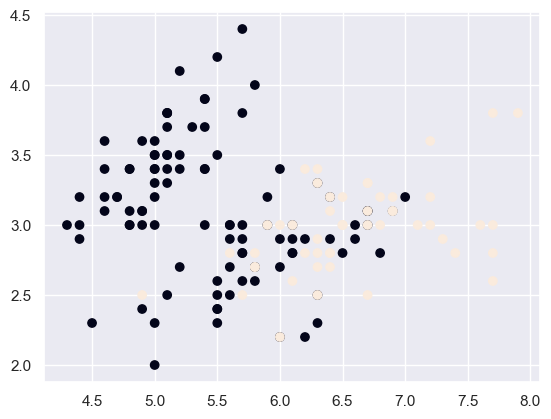

In [425]:
plt.scatter(X[:, 0], X[:, 1], c=y)

# AdaBoost demonstration 
Demonstrate your AdaBoost implementation.

Add plots and figures. 

Please use the cell below to describe your results and tests.

Describe the difference between your implementation and the sklearn implementation. Hint: you can look at the documentation.

In [426]:
def print_plots(model, X_train, X_test, y_train, y_test, extra_title=None):
    plot_idx_x = 0
    plot_idx_y = 0
    plot_step = 0.02  # fine step width for decision surface contours
    plot_step_coarser = 0.5  # step widths for coarse classifier guesses
    cmap = plt.cm.RdYlBu
    accuracies_list_internal = []

    list_range = range(len(X_train[1]))
    all_pairs = [(a, b) for idx, a in enumerate(list_range) for b in list_range[idx + 1:]]
    num_of_rows = int(len(all_pairs) / 2) if len(all_pairs) % 2 == 0 else int(len(all_pairs) / 2) + 1
    fig, axs = plt.subplots(num_of_rows, 2, figsize=(15, 20))
    for pair in all_pairs:
        X_train_pair = X_train[:,pair]
        X_test_pair = X_test[:,pair]
        
        # Train
        res = model.fit(X_train_pair, y_train)
        #Predict the response for test dataset
        y_pred = res.predict(X_test_pair)
        y_train_pred = res.predict(X_train_pair)

        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_pred)
        # Create a title for each column and the console by using str() and
        # slicing away useless parts of the string
        model_title = type(model).__name__[: -len("Classifier")]

        if extra_title:
            model_title += f" {extra_title}"
        
        model_details = model_title
        if hasattr(model, "estimators_"):
            model_details += " with {} estimators".format(len(model.estimators_))
        print(f"{model_details} with features {pair} has a score of\nTrain: {train_acc}\nTest: {test_acc}")

        accuracies_list_internal.append({
            'title': pair,
            'train_acc': train_acc,
            'test_acc': test_acc
        })
        
        axs[plot_idx_x, plot_idx_y].plot()
        axs[plot_idx_x, plot_idx_y].set_title(f"{model_title} decision boundary with features {pair}", fontsize=9)
        #axs[plot_idx_x, 1].plot()
        #axs[plot_idx_x, 1].set_title(f"{model_title} decision score with features {pair}", fontsize=9)
    
        # Now plot the decision boundary using a fine mesh as input to a
        # filled contour plot
        x_min, x_max = X_train_pair[:, 0].min() - 1, X_train_pair[:, 0].max() + 1
        y_min, y_max = X_train_pair[:, 1].min() - 1, X_train_pair[:, 1].max() + 1
        xx, yy = np.meshgrid(
            np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)
        )

        # Plot either a single DecisionTreeClassifier or alpha blend the
        # decision surfaces of the ensemble of classifiers
        if type(model).__name__ in ["DecisionTreeClassifier", "GradientBoostingClassifier"]:
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            cs = axs[plot_idx_x, plot_idx_y].contourf(xx, yy, Z, cmap=cmap)
        else:
            # Choose alpha blend level with respect to the number
            # of estimators
            # that are in use (noting that AdaBoost can use fewer estimators
            # than its maximum if it achieves a good enough fit early on)
            estimator_alpha = 1.0 / len(model.estimators_)
            for tree in model.estimators_:
                Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
                Z = Z.reshape(xx.shape)
                cs = axs[plot_idx_x, plot_idx_y].contourf(xx, yy, Z, alpha=estimator_alpha, cmap=cmap)
    
        # Build a coarser grid to plot a set of ensemble classifications
        # to show how these are different to what we see in the decision
        # surfaces. These points are regularly space and do not have a
        # black outline
        xx_coarser, yy_coarser = np.meshgrid(
            np.arange(x_min, x_max, plot_step_coarser),
            np.arange(y_min, y_max, plot_step_coarser),
        )
        Z_points_coarser = res.predict(
            np.c_[xx_coarser.ravel(), yy_coarser.ravel()]
        ).reshape(xx_coarser.shape)
        cs_points = axs[plot_idx_x, plot_idx_y].scatter(
            xx_coarser,
            yy_coarser,
            s=15,
            c=Z_points_coarser,
            cmap=cmap,
            edgecolors="none",
        )
    
        # Plot the training points, these are clustered together and have a
        # black outline
        axs[plot_idx_x, plot_idx_y].scatter(
            X_train_pair[:, 0],
            X_train_pair[:, 1],
            c=y_train,
            marker="o",
            cmap=ListedColormap(["r", "y", "b"]),
            edgecolor="k",
            s=20,
        )
        axs[plot_idx_x, plot_idx_y].scatter(
            X_test_pair[:, 0],
            X_test_pair[:, 1],
            c=y_pred,
            marker="X",
            cmap=ListedColormap(["g", "w", "m"]),
            edgecolor="k",
            s=20,
        )
        
        #plot_idx_x += 1
        plot_idx_y += 1  # move on to the next plot in sequence
        if (plot_idx_y % 2 == 0):
            plot_idx_x += 1
            plot_idx_y = 0
    
    plt.suptitle(f"Classifiers on feature subsets of the {extra_title} dataset", fontsize=12)
    plt.axis("tight")
    plt.tight_layout(h_pad=1, w_pad=1, pad=10)
    plt.show()

    accuracies_list_df = pd.DataFrame.from_records(accuracies_list_internal)
    accuracies_list_df.plot.bar(x='title', y=['train_acc', 'test_acc'])

Accuracy of AdaBoostSklearn:
Train:0.9809523809523809
Test:0.9555555555555556


/Users/scohen6/projects/idc_msc/advanced-ml/exc1/venv/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


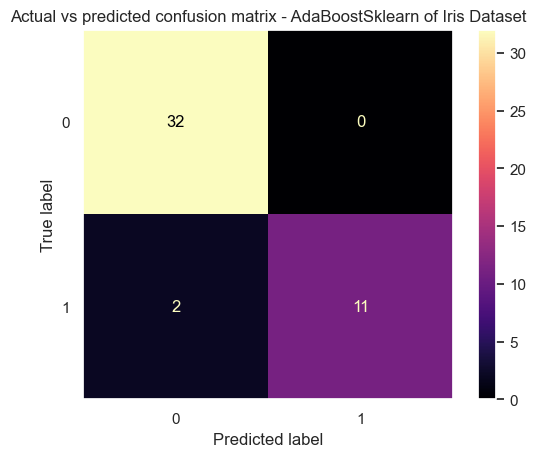

/Users/scohen6/projects/idc_msc/advanced-ml/exc1/venv/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/scohen6/projects/idc_msc/advanced-ml/exc1/venv/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/scohen6/projects/idc_msc/advanced-ml/exc1/venv/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Iris with 10 estimators with features (0, 1) has a score of
Train: 0.819047619047619
Test: 0.8222222222222222
AdaBoost Iris with 10 estimators with features (0, 2) has a score of
Train: 0.9714285714285714
Test: 0.9333333333333333
AdaBoost Iris with 10 estimators with features (0, 3) has a score of
Train: 0.9619047619047619
Test: 0.9111111111111111


/Users/scohen6/projects/idc_msc/advanced-ml/exc1/venv/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/scohen6/projects/idc_msc/advanced-ml/exc1/venv/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/scohen6/projects/idc_msc/advanced-ml/exc1/venv/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Iris with 10 estimators with features (1, 2) has a score of
Train: 0.9619047619047619
Test: 0.8888888888888888
AdaBoost Iris with 10 estimators with features (1, 3) has a score of
Train: 0.9619047619047619
Test: 0.9777777777777777
AdaBoost Iris with 10 estimators with features (2, 3) has a score of
Train: 0.9714285714285714
Test: 1.0


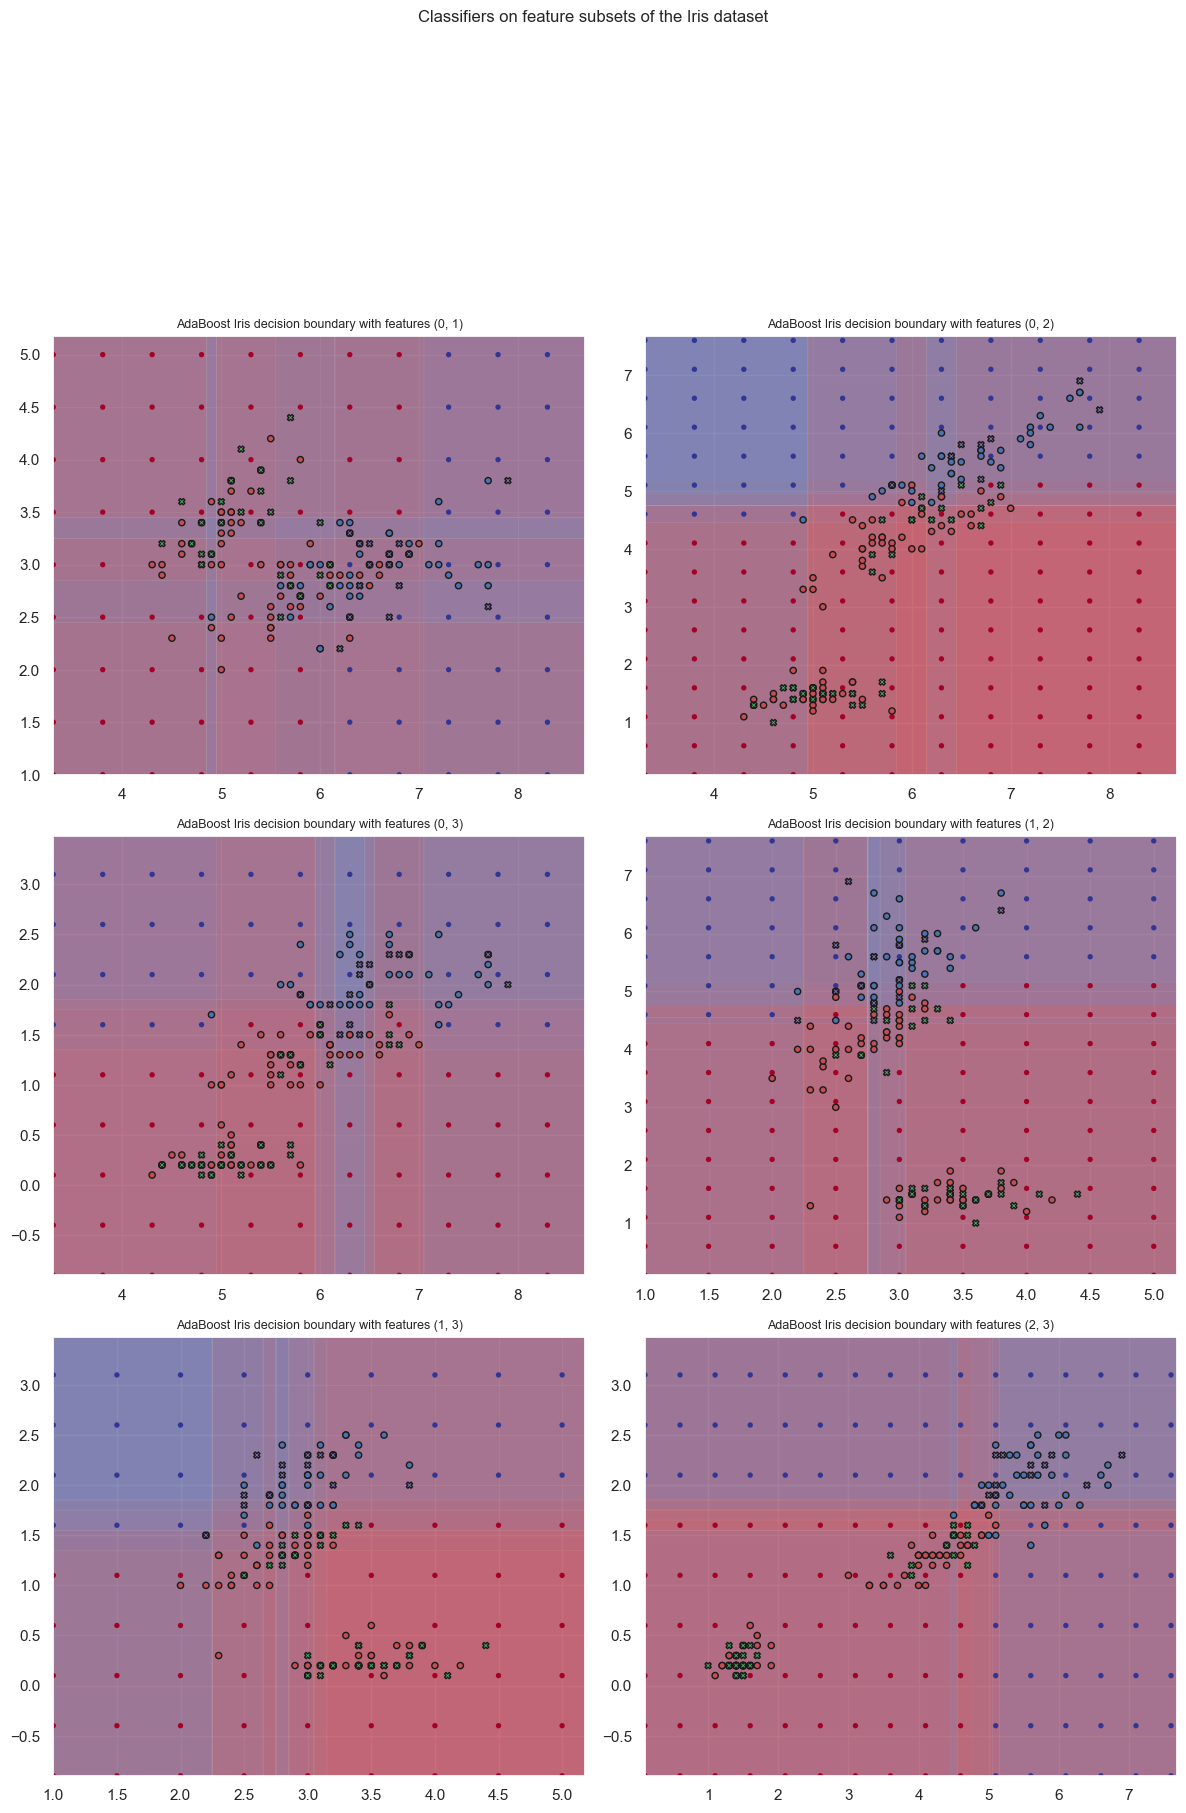

Accuracy of AdaBoostCustom:
Train:0.9714285714285714
Test:1.0


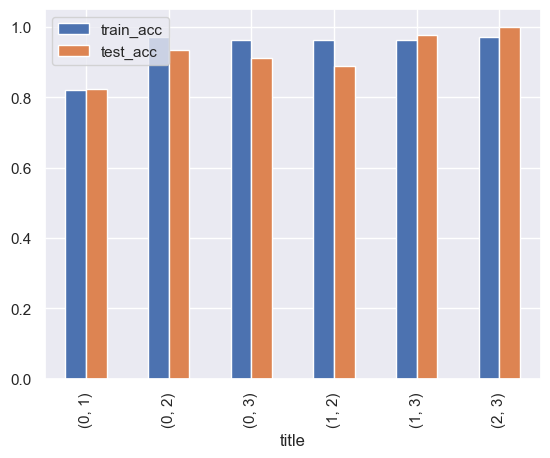

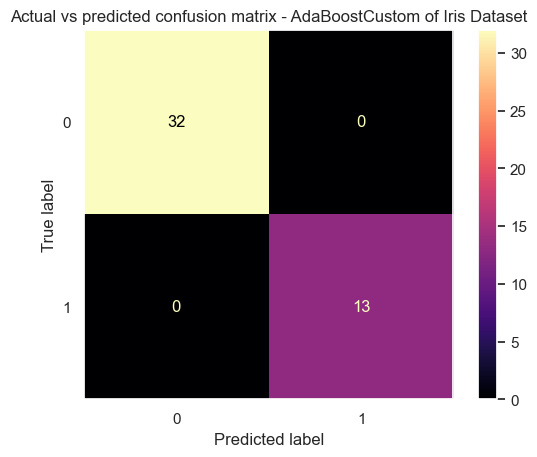

AdaB Iris with 10 estimators with features (0, 1) has a score of
Train: 0.819047619047619
Test: 0.8222222222222222
AdaB Iris with 10 estimators with features (0, 2) has a score of
Train: 0.9619047619047619
Test: 0.9777777777777777
AdaB Iris with 10 estimators with features (0, 3) has a score of
Train: 0.9428571428571428
Test: 1.0
AdaB Iris with 10 estimators with features (1, 2) has a score of
Train: 0.9619047619047619
Test: 0.9111111111111111
AdaB Iris with 10 estimators with features (1, 3) has a score of
Train: 0.9428571428571428
Test: 1.0
AdaB Iris with 10 estimators with features (2, 3) has a score of
Train: 0.9523809523809523
Test: 1.0


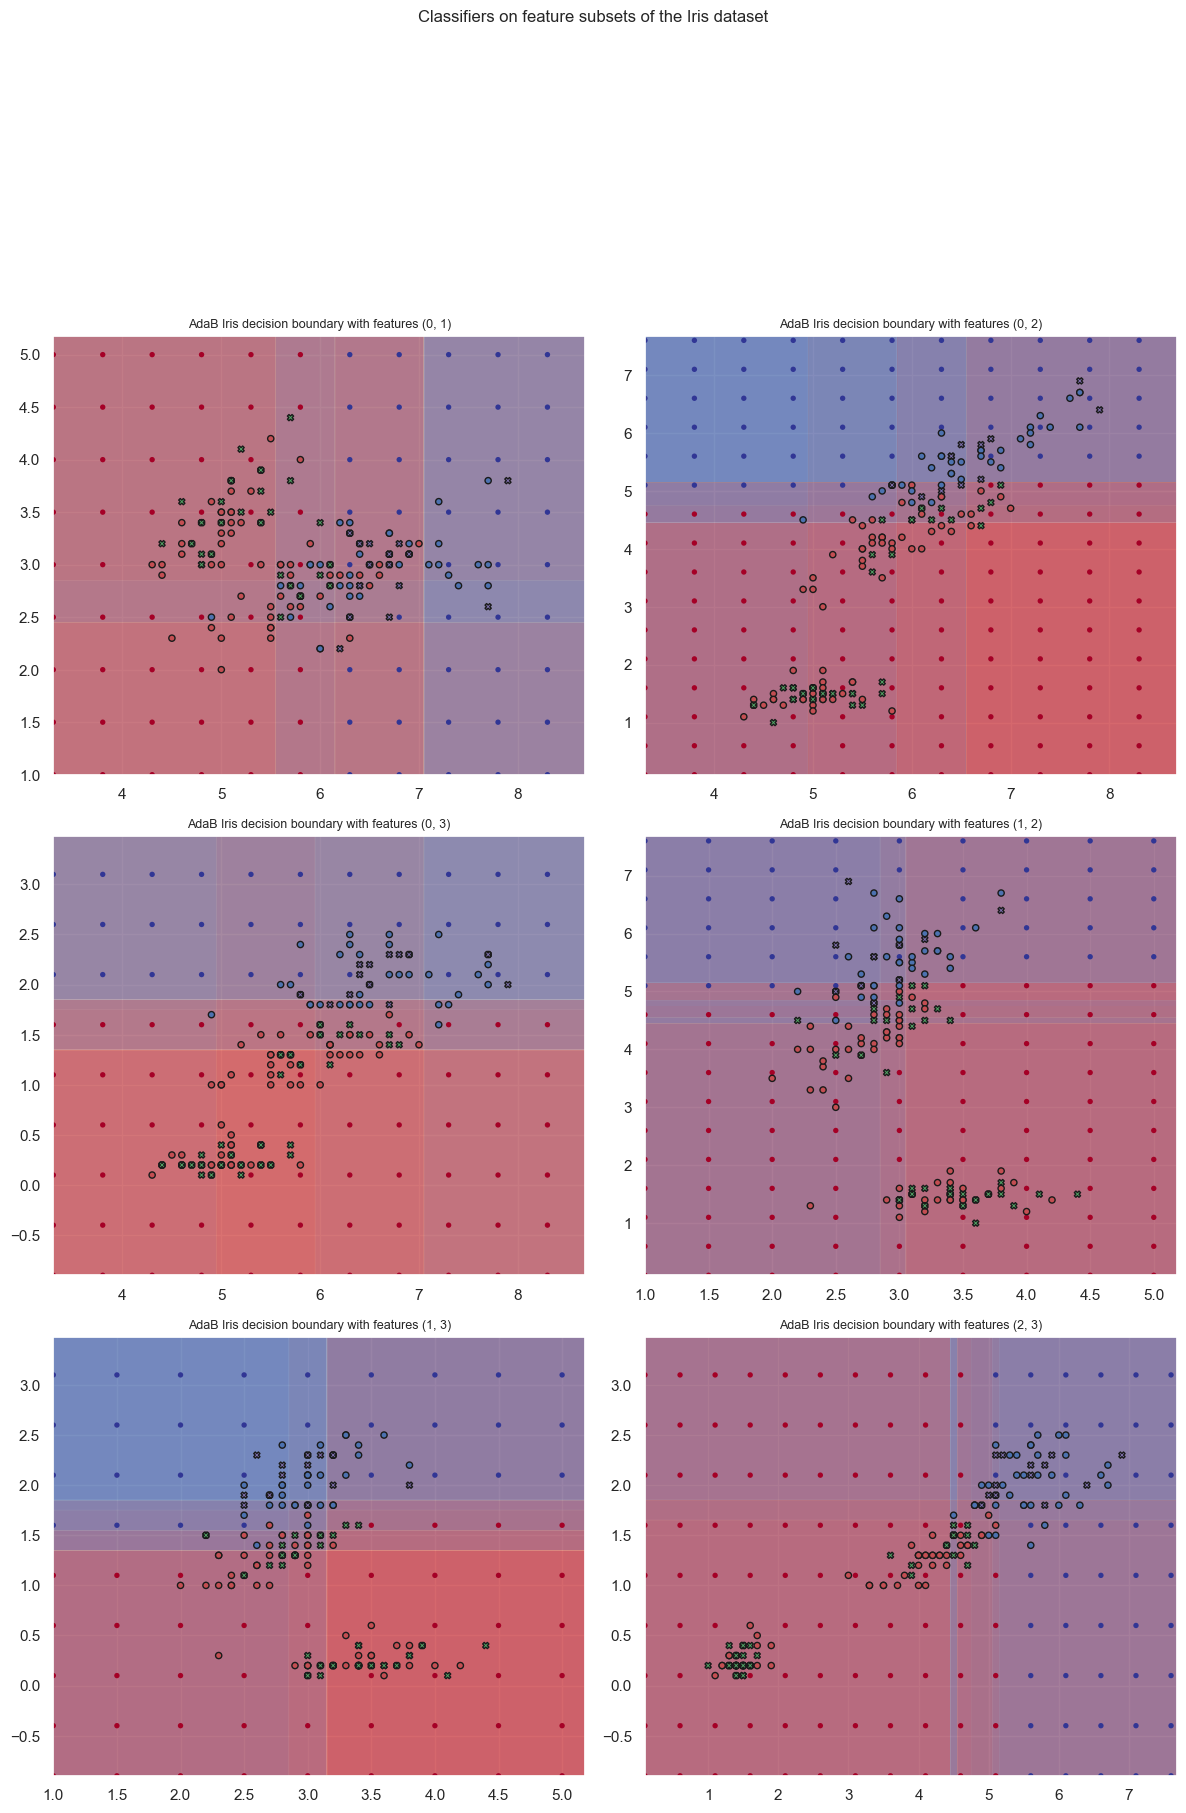

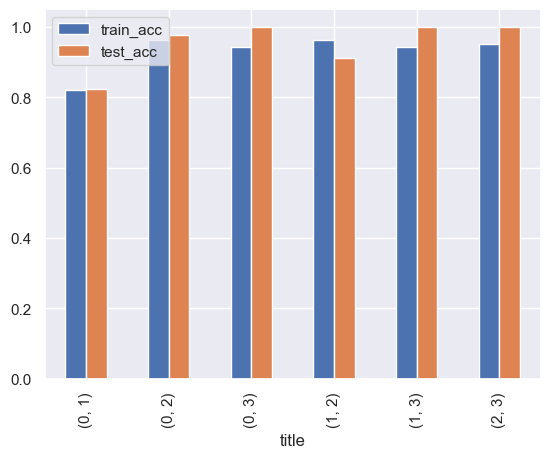

In [427]:
models = [
    AdaBoostClassifier(n_estimators=10, random_state=42),
    AdaBoostCustom(T=10, verbose=False)
]

accuracies_list = []

for model in models:
    # Train Adaboost Classifer
    res = model.fit(X_train, y_train)
    
    #Predict the response for test dataset
    y_train_pred = res.predict(X_train)
    y_pred = res.predict(X_test)

    model_title = type(model).__name__.replace("Classifier", "Sklearn")

    accuracies_list.append({
        "title": f"{model_title} of Iris Dataset",
        "train_acc": accuracy_score(y_train, y_train_pred),
        "test_acc": accuracy_score(y_test, y_pred)
    })
    
    # Model Accuracy, how often is the classifier correct?
    print(f"Accuracy of {model_title}:\nTrain:{accuracy_score(y_train, y_train_pred)}\nTest:{accuracy_score(y_test, y_pred)}")
    
    matrix_plot = confusion_matrix(y_test, y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=matrix_plot)
    cm_display.plot(cmap="magma")
    plt.title(
        f"Actual vs predicted confusion matrix - {model_title} of Iris Dataset"
    )
    plt.grid(False)
    plt.show()

    print_plots(model, X_train, X_test, y_train, y_test, "Iris")

# Generate additional data sets
Generate at least two experimental datasets with binary labels, designed to demonstrate specific properties of AdaBoost (e.g., handling noise or overfitting).

Add plots and figures.

Please use the cell below to describe your suggested approach in detail. Use formal notations where appropriate.

Describe and discuss your results.

Accuracy of AdaBoostSklearn:
Train:0.75
Test:0.6166666666666667


/Users/scohen6/projects/idc_msc/advanced-ml/exc1/venv/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


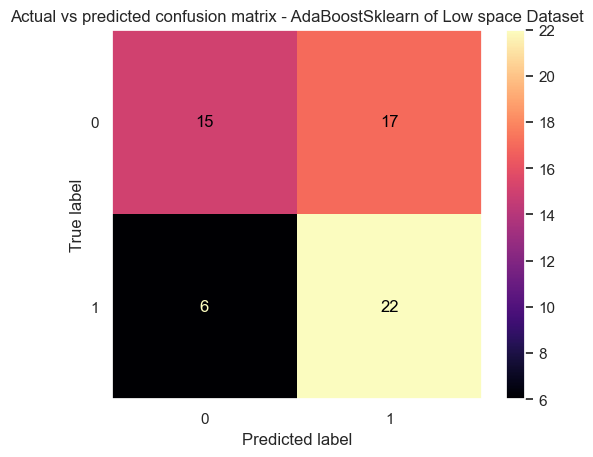

/Users/scohen6/projects/idc_msc/advanced-ml/exc1/venv/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Low space Dataset with 10 estimators with features (0, 1) has a score of
Train: 0.6214285714285714
Test: 0.4666666666666667


/Users/scohen6/projects/idc_msc/advanced-ml/exc1/venv/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Low space Dataset with 10 estimators with features (0, 2) has a score of
Train: 0.7214285714285714
Test: 0.5666666666666667


/Users/scohen6/projects/idc_msc/advanced-ml/exc1/venv/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Low space Dataset with 10 estimators with features (0, 3) has a score of
Train: 0.65
Test: 0.43333333333333335


/Users/scohen6/projects/idc_msc/advanced-ml/exc1/venv/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Low space Dataset with 10 estimators with features (1, 2) has a score of
Train: 0.7428571428571429
Test: 0.5166666666666667


/Users/scohen6/projects/idc_msc/advanced-ml/exc1/venv/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Low space Dataset with 10 estimators with features (1, 3) has a score of
Train: 0.7
Test: 0.4666666666666667


/Users/scohen6/projects/idc_msc/advanced-ml/exc1/venv/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Low space Dataset with 10 estimators with features (2, 3) has a score of
Train: 0.7642857142857142
Test: 0.6


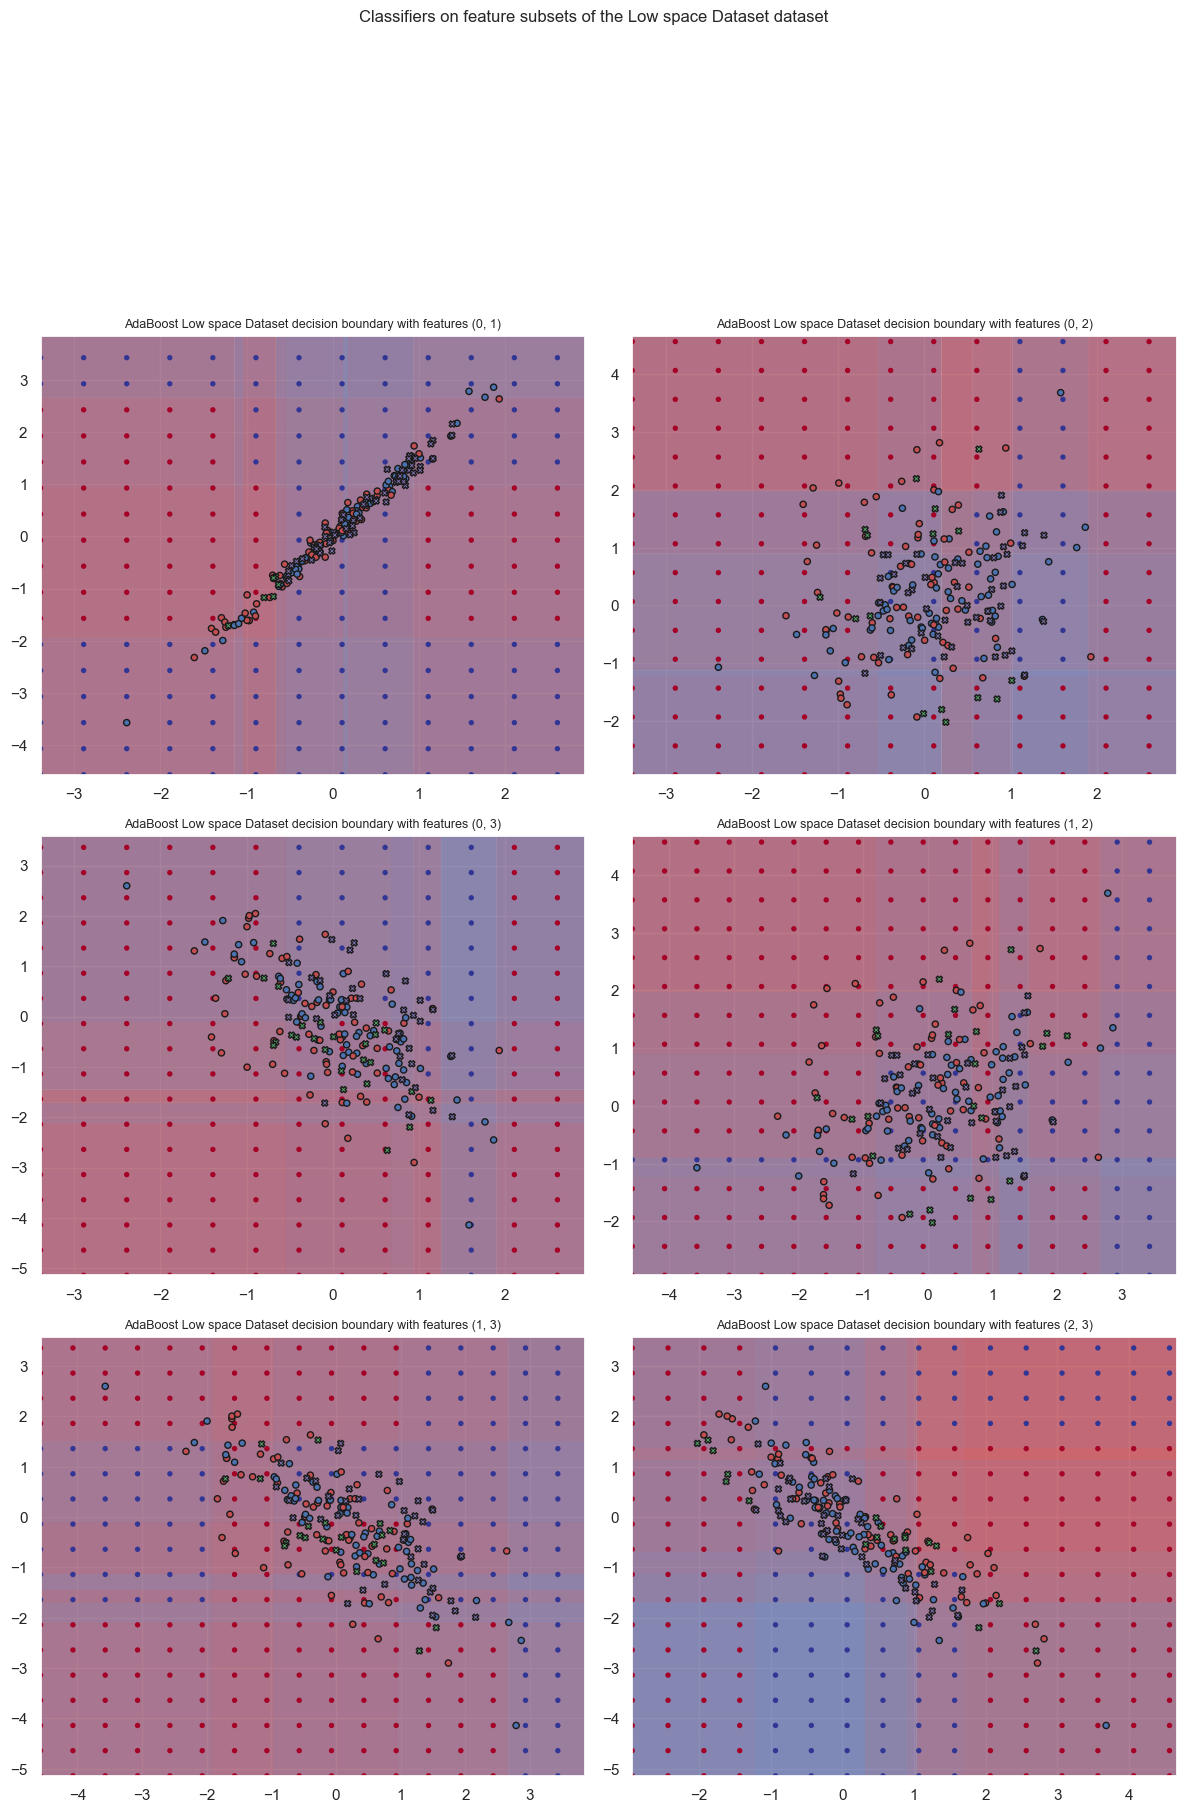

Accuracy of AdaBoostSklearn:
Train:0.8142857142857143
Test:0.7166666666666667


/Users/scohen6/projects/idc_msc/advanced-ml/exc1/venv/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


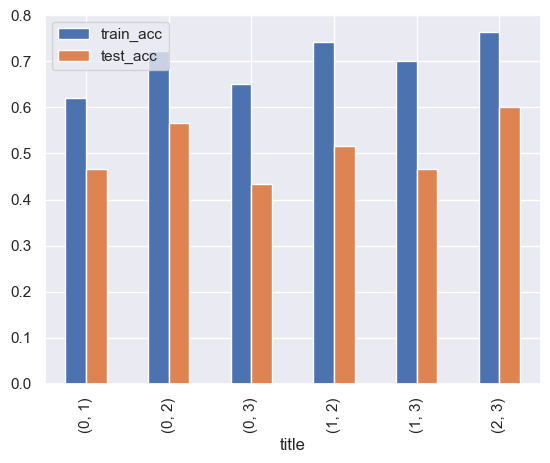

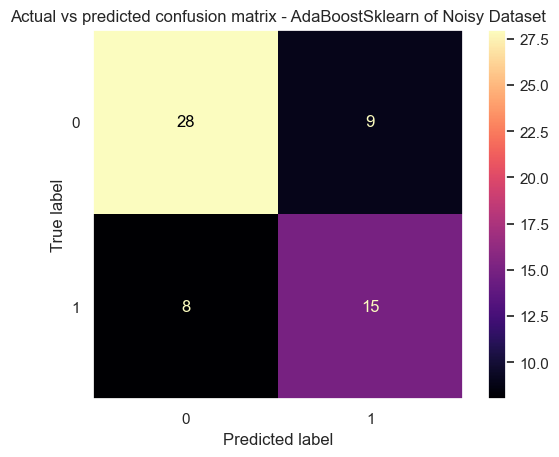

/Users/scohen6/projects/idc_msc/advanced-ml/exc1/venv/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/scohen6/projects/idc_msc/advanced-ml/exc1/venv/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Noisy Dataset with 10 estimators with features (0, 1) has a score of
Train: 0.7785714285714286
Test: 0.7333333333333333
AdaBoost Noisy Dataset with 10 estimators with features (0, 2) has a score of
Train: 0.7714285714285715
Test: 0.6166666666666667


/Users/scohen6/projects/idc_msc/advanced-ml/exc1/venv/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/scohen6/projects/idc_msc/advanced-ml/exc1/venv/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Noisy Dataset with 10 estimators with features (0, 3) has a score of
Train: 0.7714285714285715
Test: 0.75
AdaBoost Noisy Dataset with 10 estimators with features (1, 2) has a score of
Train: 0.8
Test: 0.7333333333333333


/Users/scohen6/projects/idc_msc/advanced-ml/exc1/venv/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/scohen6/projects/idc_msc/advanced-ml/exc1/venv/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Noisy Dataset with 10 estimators with features (1, 3) has a score of
Train: 0.8
Test: 0.75
AdaBoost Noisy Dataset with 10 estimators with features (2, 3) has a score of
Train: 0.7857142857142857
Test: 0.7166666666666667


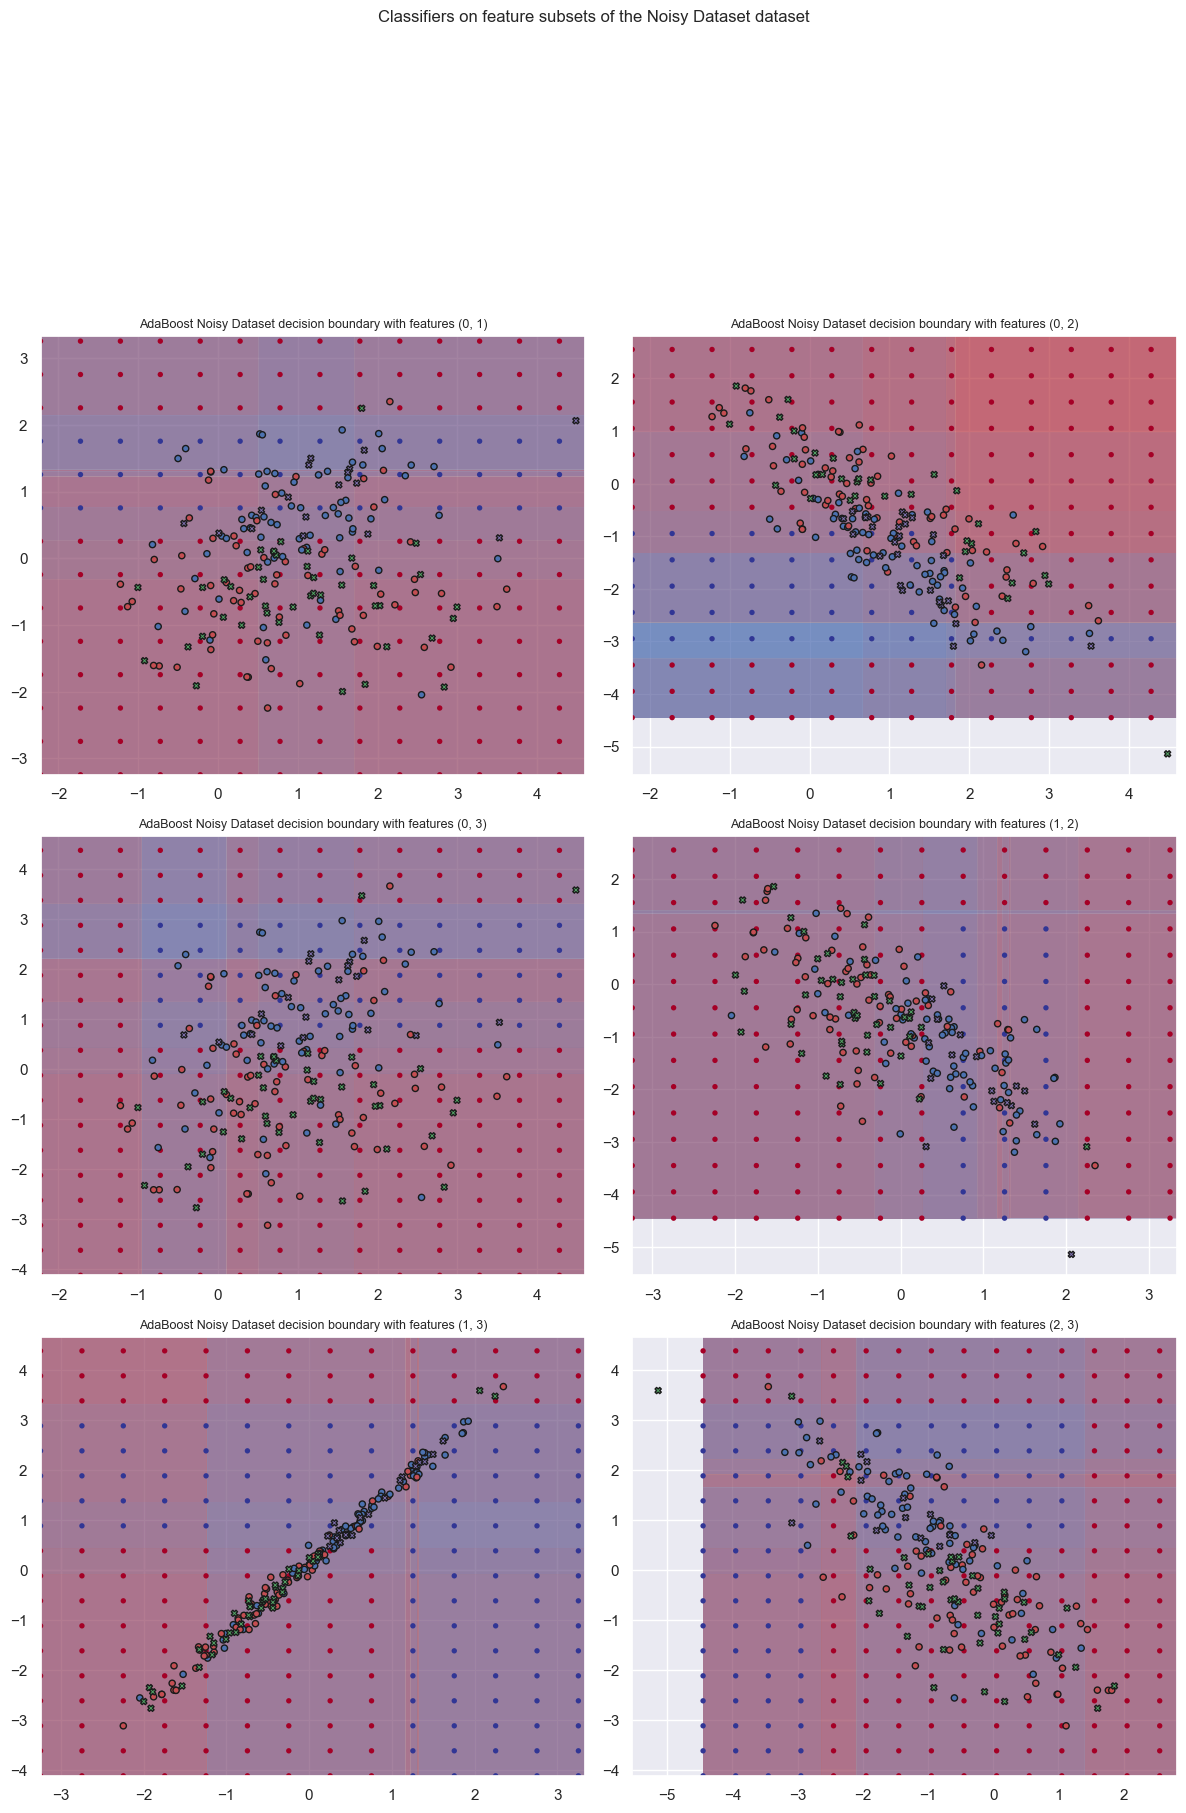

Accuracy of AdaBoostCustom:
Train:0.6
Test:0.55


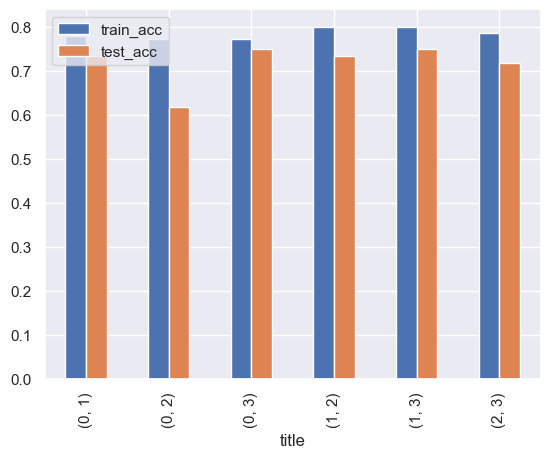

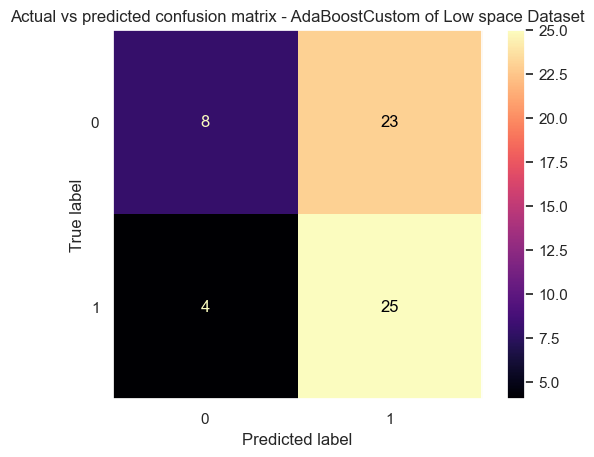

AdaB Low space Dataset with 10 estimators with features (0, 1) has a score of
Train: 0.6142857142857143
Test: 0.5166666666666667
AdaB Low space Dataset with 10 estimators with features (0, 2) has a score of
Train: 0.5928571428571429
Test: 0.55
AdaB Low space Dataset with 10 estimators with features (0, 3) has a score of
Train: 0.6
Test: 0.5166666666666667
AdaB Low space Dataset with 10 estimators with features (1, 2) has a score of
Train: 0.6
Test: 0.55
AdaB Low space Dataset with 10 estimators with features (1, 3) has a score of
Train: 0.6142857142857143
Test: 0.5166666666666667
AdaB Low space Dataset with 10 estimators with features (2, 3) has a score of
Train: 0.6071428571428571
Test: 0.55


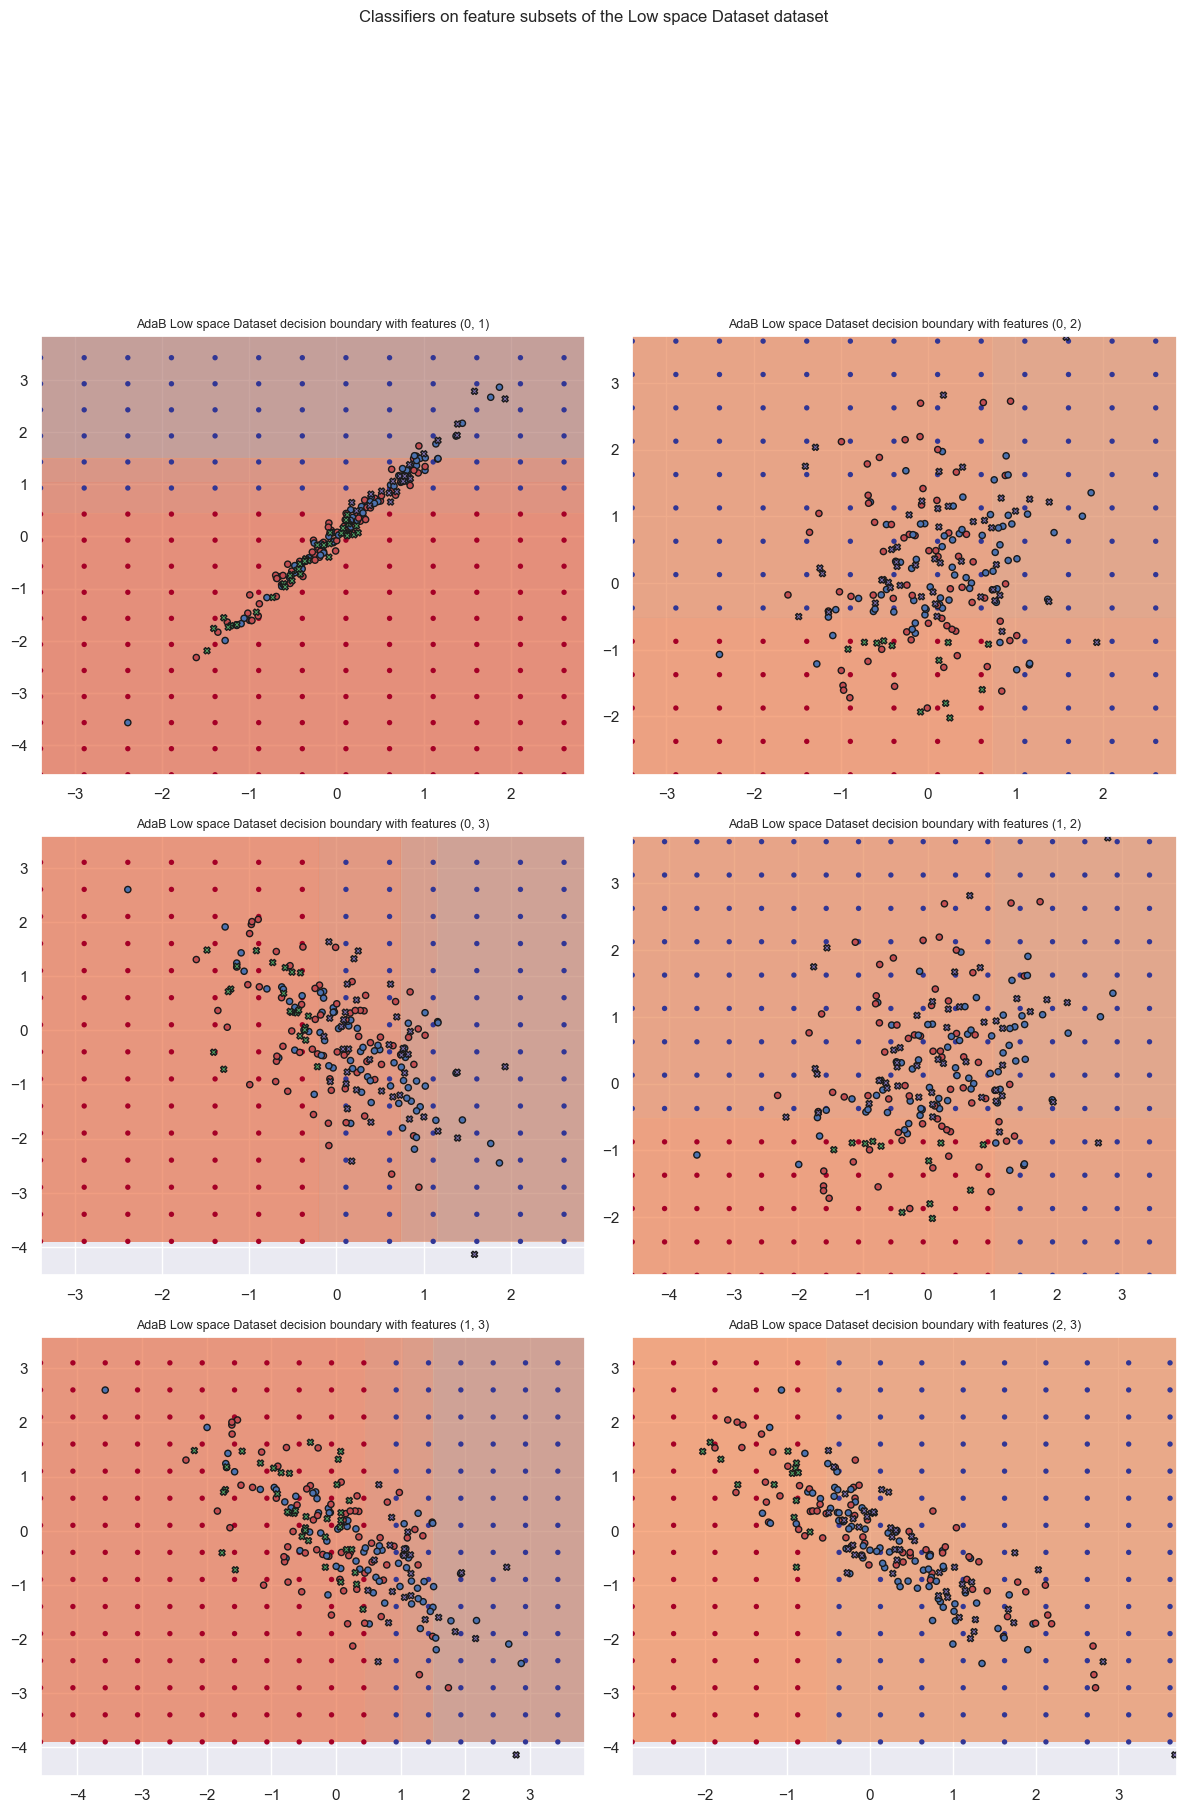

Accuracy of AdaBoostCustom:
Train:0.7714285714285715
Test:0.75


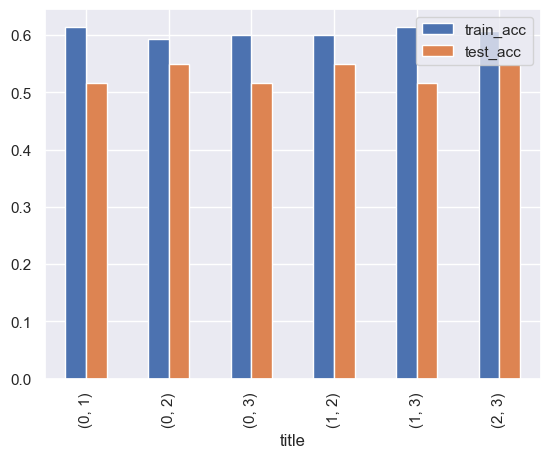

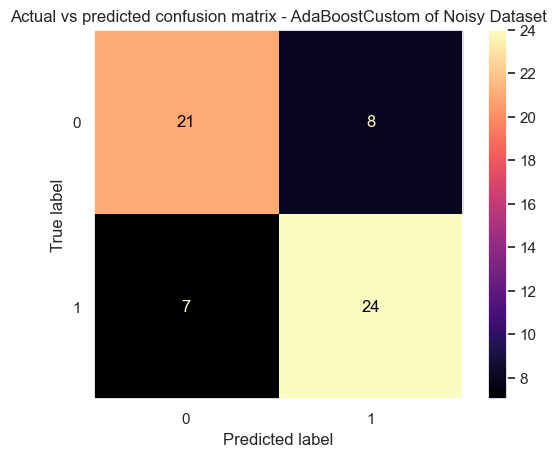

AdaB Noisy Dataset with 10 estimators with features (0, 1) has a score of
Train: 0.75
Test: 0.7666666666666667
AdaB Noisy Dataset with 10 estimators with features (0, 2) has a score of
Train: 0.6357142857142857
Test: 0.6166666666666667
AdaB Noisy Dataset with 10 estimators with features (0, 3) has a score of
Train: 0.7714285714285715
Test: 0.75
AdaB Noisy Dataset with 10 estimators with features (1, 2) has a score of
Train: 0.75
Test: 0.7666666666666667
AdaB Noisy Dataset with 10 estimators with features (1, 3) has a score of
Train: 0.7714285714285715
Test: 0.75
AdaB Noisy Dataset with 10 estimators with features (2, 3) has a score of
Train: 0.7714285714285715
Test: 0.75


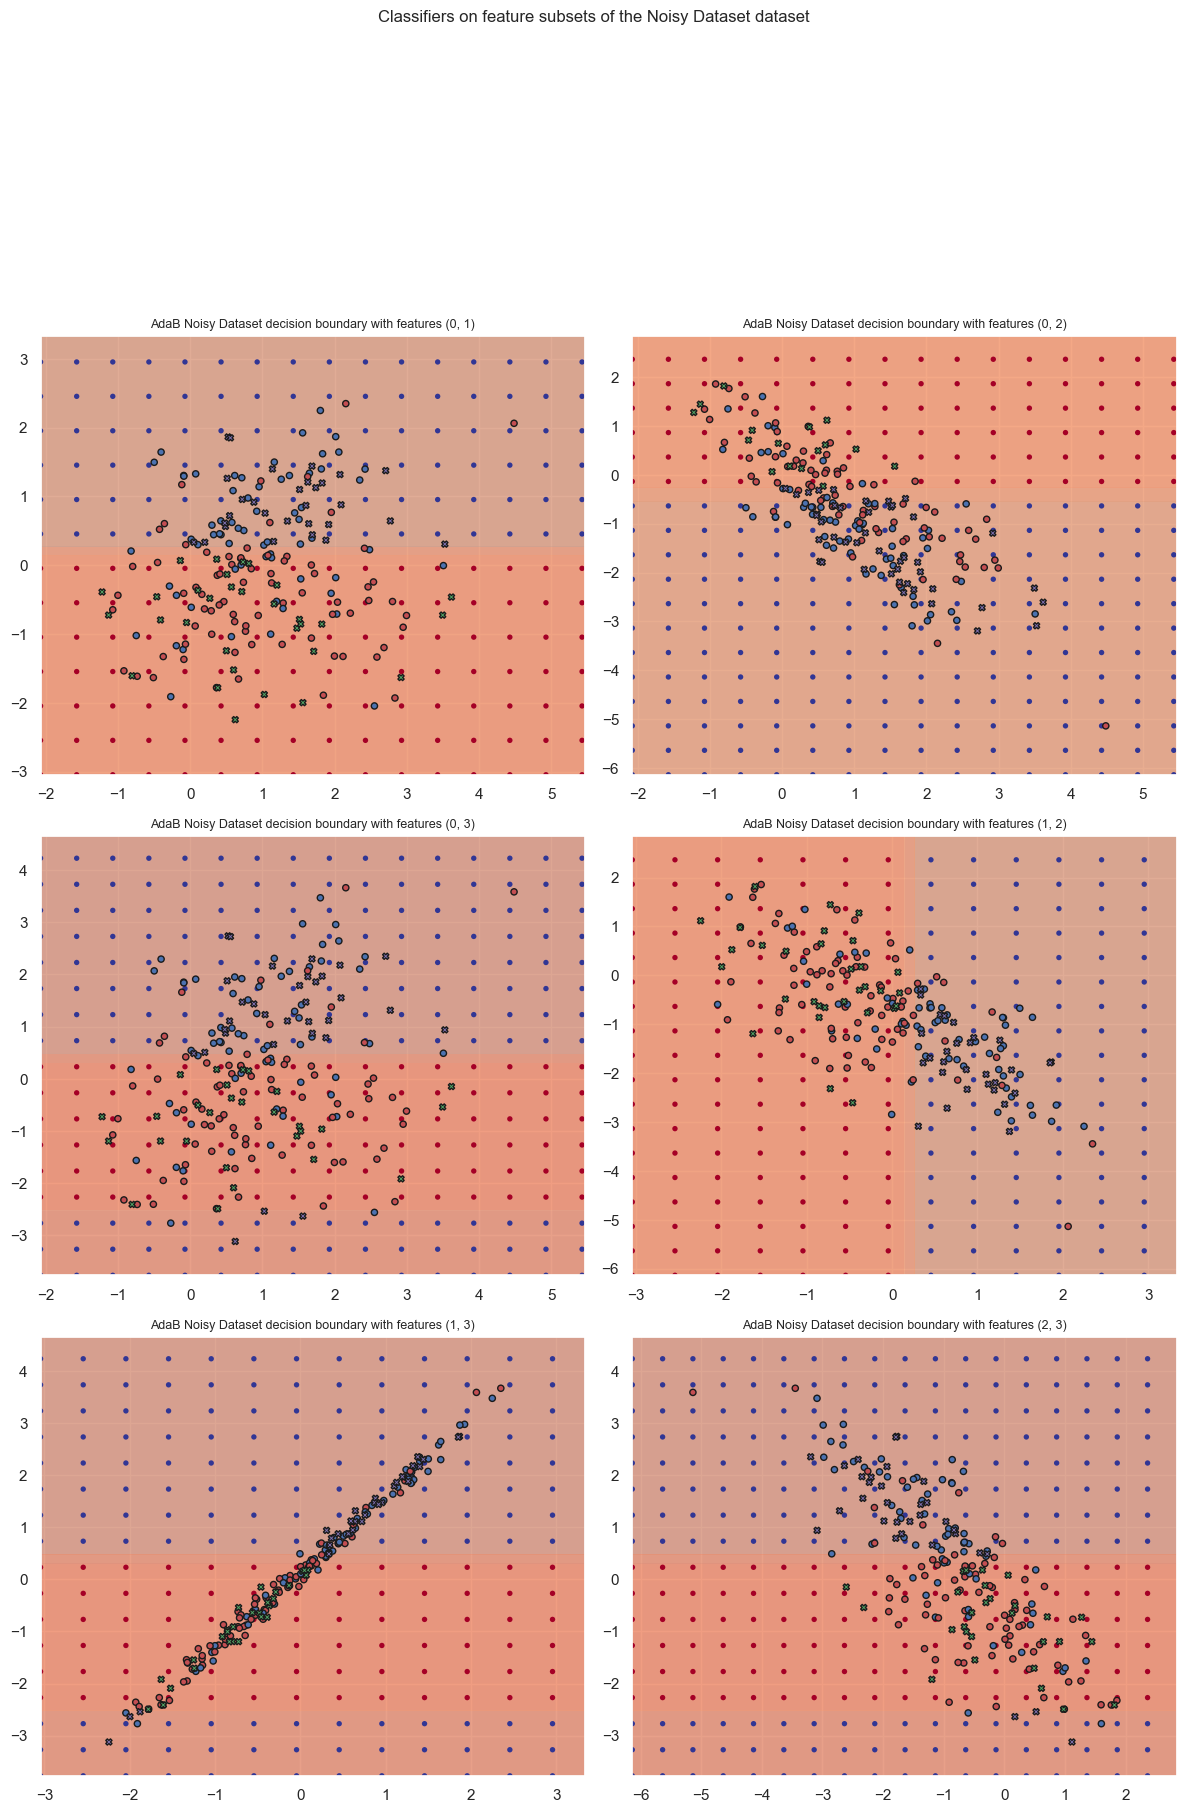

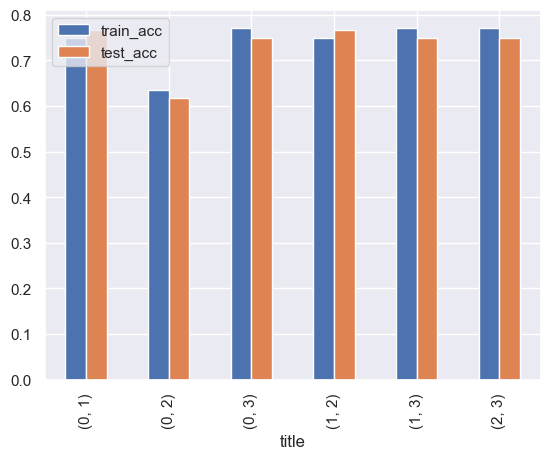

In [428]:
datasets = [{
    'n_samples': 200,
    'n_features': 4,
    'n_informative': 2,
    'n_classes': 2,
    'n_clusters_per_class': 1,
    'flip_y': 0.01, # Default flip value, no noise
    'class_sep': 0.2, # Reduces the space between label classes
    'title': "Low space Dataset"
},{
    'n_samples': 200,
    'n_features': 4,
    'n_informative': 2,
    'n_classes': 2,
    'n_clusters_per_class': 1,
    'flip_y': 0.5, # Makes a noisy dataset
    'class_sep': 1, # Default space seperation
    'title': "Noisy Dataset"
}]

models = [
    AdaBoostClassifier(n_estimators=10, random_state=42),
    AdaBoostCustom(T=10, verbose=False)
]

for model in models:
    for dataset in datasets:
        X, y = make_classification(
            n_samples = dataset['n_samples'],
            n_features = dataset['n_features'],
            n_informative = dataset['n_informative'],
            n_classes = dataset['n_classes'],
            n_clusters_per_class = dataset['n_clusters_per_class'],
            flip_y = dataset['flip_y'],
            class_sep = dataset['class_sep'],
            random_state=42
        )
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test
    
        # Train Adaboost Classifer
        res = model.fit(X_train, y_train)

        #Predict the response for test dataset
        y_train_pred = res.predict(X_train)
        y_pred = res.predict(X_test)
    
        model_title = type(model).__name__.replace("Classifier", "Sklearn")

        accuracies_list.append({
            "title": f"{model_title} of {dataset['title']}",
            "train_acc": accuracy_score(y_train, y_train_pred),
            "test_acc": accuracy_score(y_test, y_pred)
        })
        
        # Model Accuracy, how often is the classifier correct?
        print(f"Accuracy of {model_title}:\nTrain:{accuracy_score(y_train, y_train_pred)}\nTest:{accuracy_score(y_test, y_pred)}")
        
        matrix_plot = confusion_matrix(y_test, y_pred)
        cm_display = ConfusionMatrixDisplay(confusion_matrix=matrix_plot)
        cm_display.plot(cmap="magma")
        plt.title(
            f"Actual vs predicted confusion matrix - {model_title} of {dataset['title']}"
        )
        plt.grid(False)
        plt.show()
    
        print_plots(model, X_train, X_test, y_train, y_test, dataset['title'])

# Test algorithms
Test your AdaBoost, a library implementation of AdaBoost and at least two additional models, one of which must be another boosting algorithm on your two datasets.

Add plots and figures.

Please use the cell below to describe your suggested approach in detail. Use formal notations where appropriate.

Describe and discuss your results.

Accuracy of RandomForest:
Train:0.9571428571428572
Test:0.5166666666666667


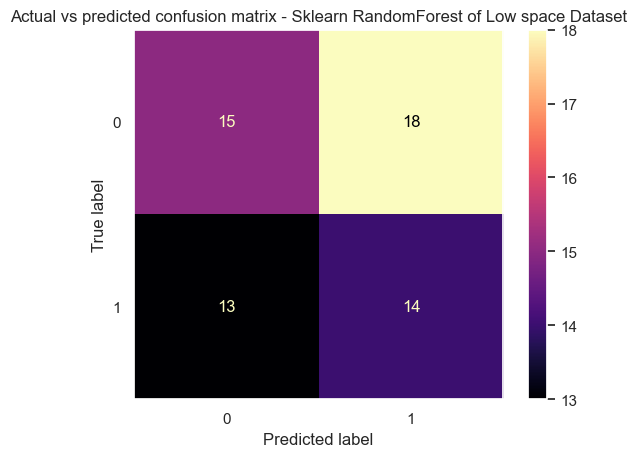

RandomForest Low space Dataset with 10 estimators with features (0, 1) has a score of
Train: 0.9785714285714285
Test: 0.4666666666666667
RandomForest Low space Dataset with 10 estimators with features (0, 2) has a score of
Train: 0.9714285714285714
Test: 0.5166666666666667
RandomForest Low space Dataset with 10 estimators with features (0, 3) has a score of
Train: 0.9857142857142858
Test: 0.5666666666666667
RandomForest Low space Dataset with 10 estimators with features (1, 2) has a score of
Train: 0.9857142857142858
Test: 0.43333333333333335
RandomForest Low space Dataset with 10 estimators with features (1, 3) has a score of
Train: 0.9928571428571429
Test: 0.6166666666666667
RandomForest Low space Dataset with 10 estimators with features (2, 3) has a score of
Train: 0.9785714285714285
Test: 0.55


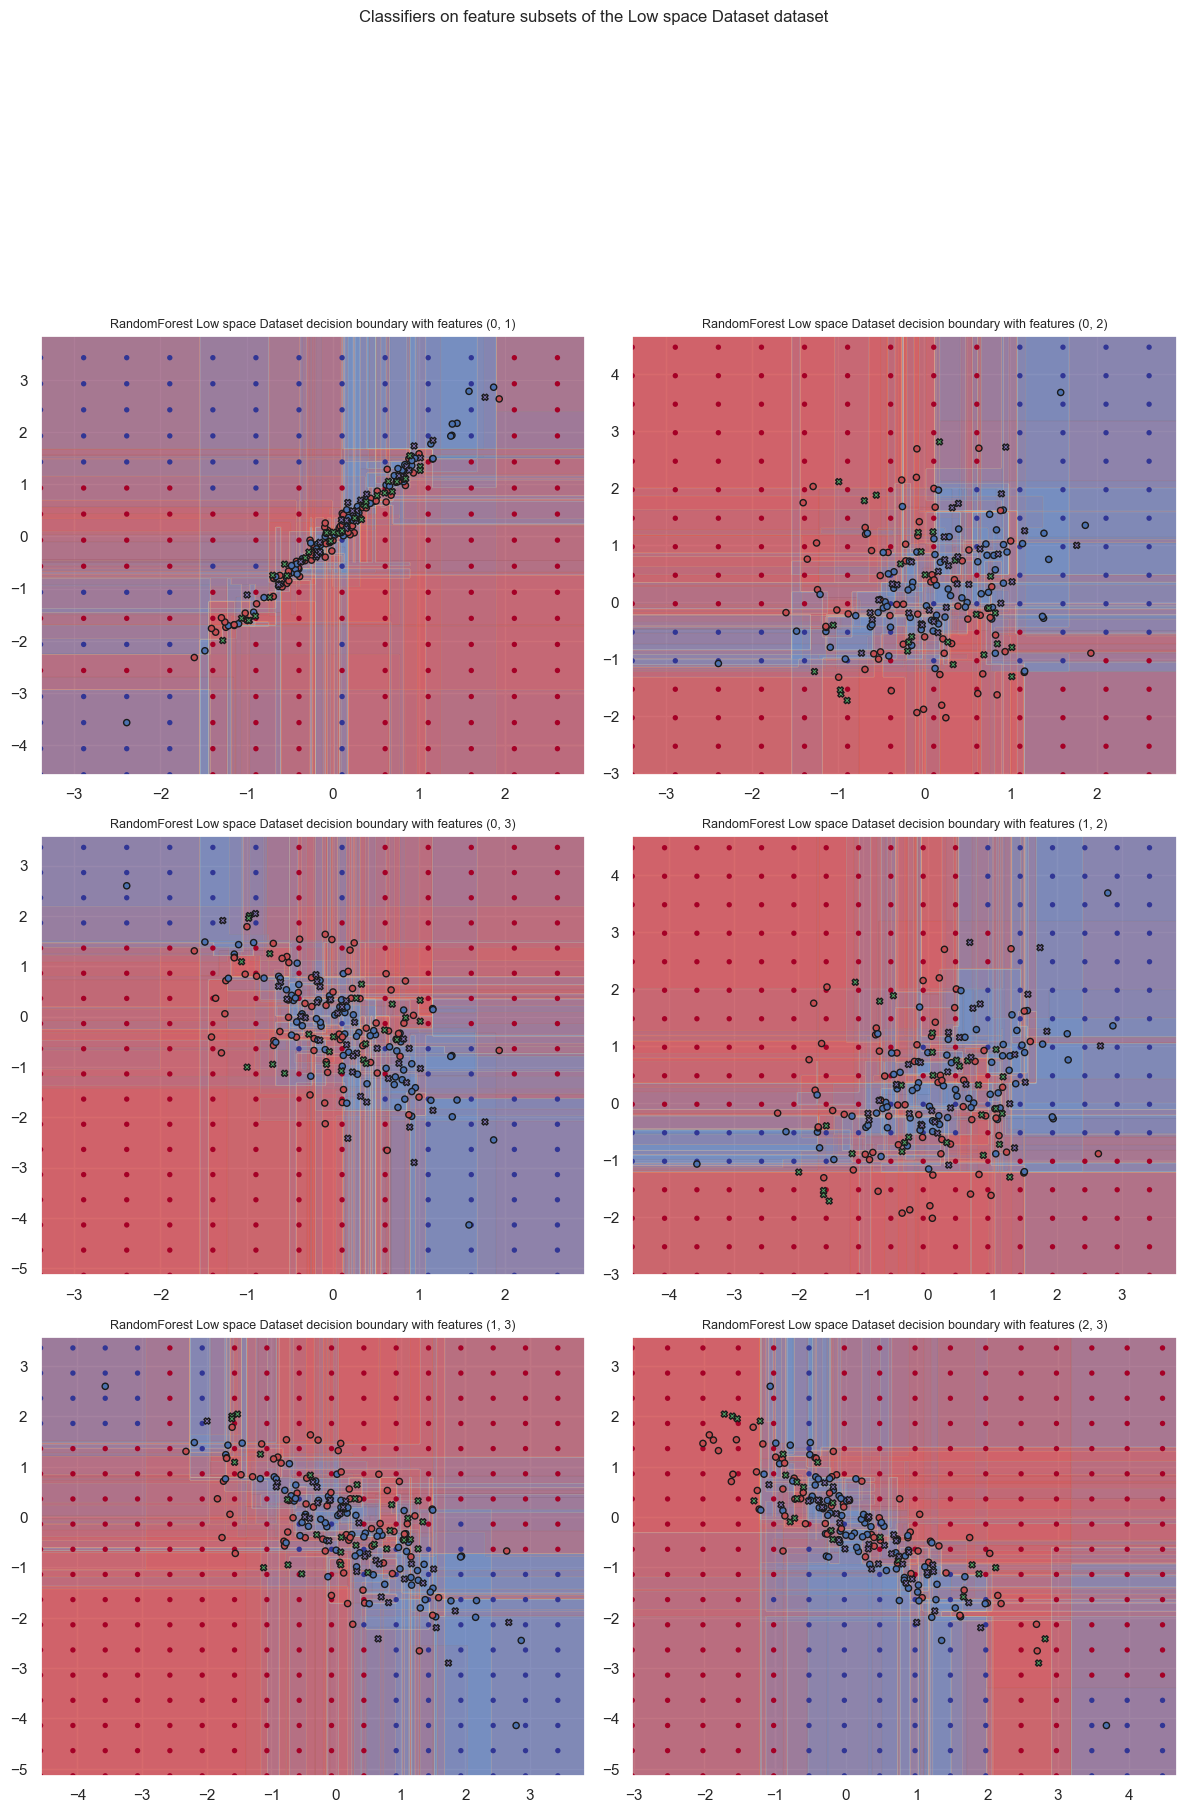

Accuracy of RandomForest:
Train:0.9714285714285714
Test:0.6333333333333333


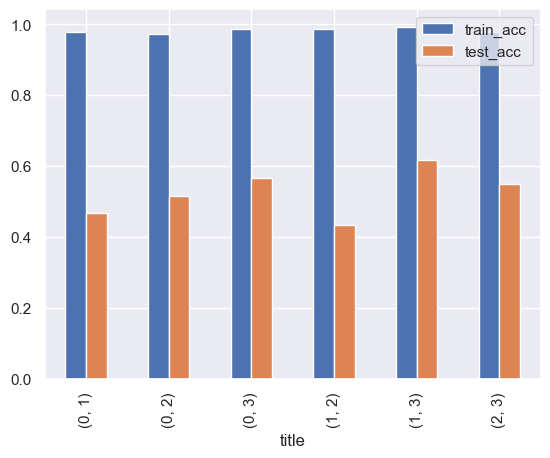

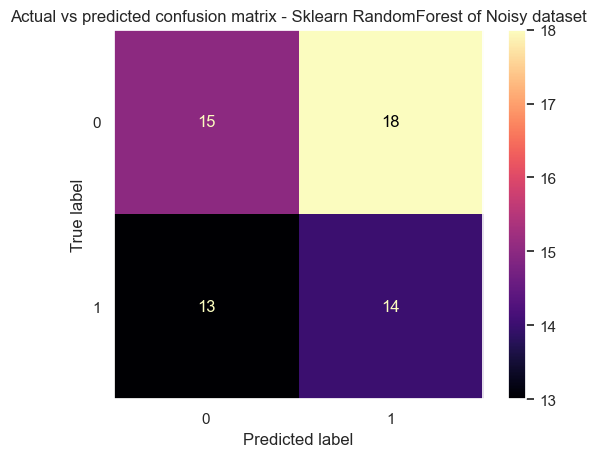

RandomForest Noisy dataset with 10 estimators with features (0, 1) has a score of
Train: 0.9714285714285714
Test: 0.6833333333333333
RandomForest Noisy dataset with 10 estimators with features (0, 2) has a score of
Train: 0.9785714285714285
Test: 0.5
RandomForest Noisy dataset with 10 estimators with features (0, 3) has a score of
Train: 0.9785714285714285
Test: 0.6166666666666667
RandomForest Noisy dataset with 10 estimators with features (1, 2) has a score of
Train: 0.9571428571428572
Test: 0.5833333333333334
RandomForest Noisy dataset with 10 estimators with features (1, 3) has a score of
Train: 0.9571428571428572
Test: 0.65
RandomForest Noisy dataset with 10 estimators with features (2, 3) has a score of
Train: 0.9714285714285714
Test: 0.6166666666666667


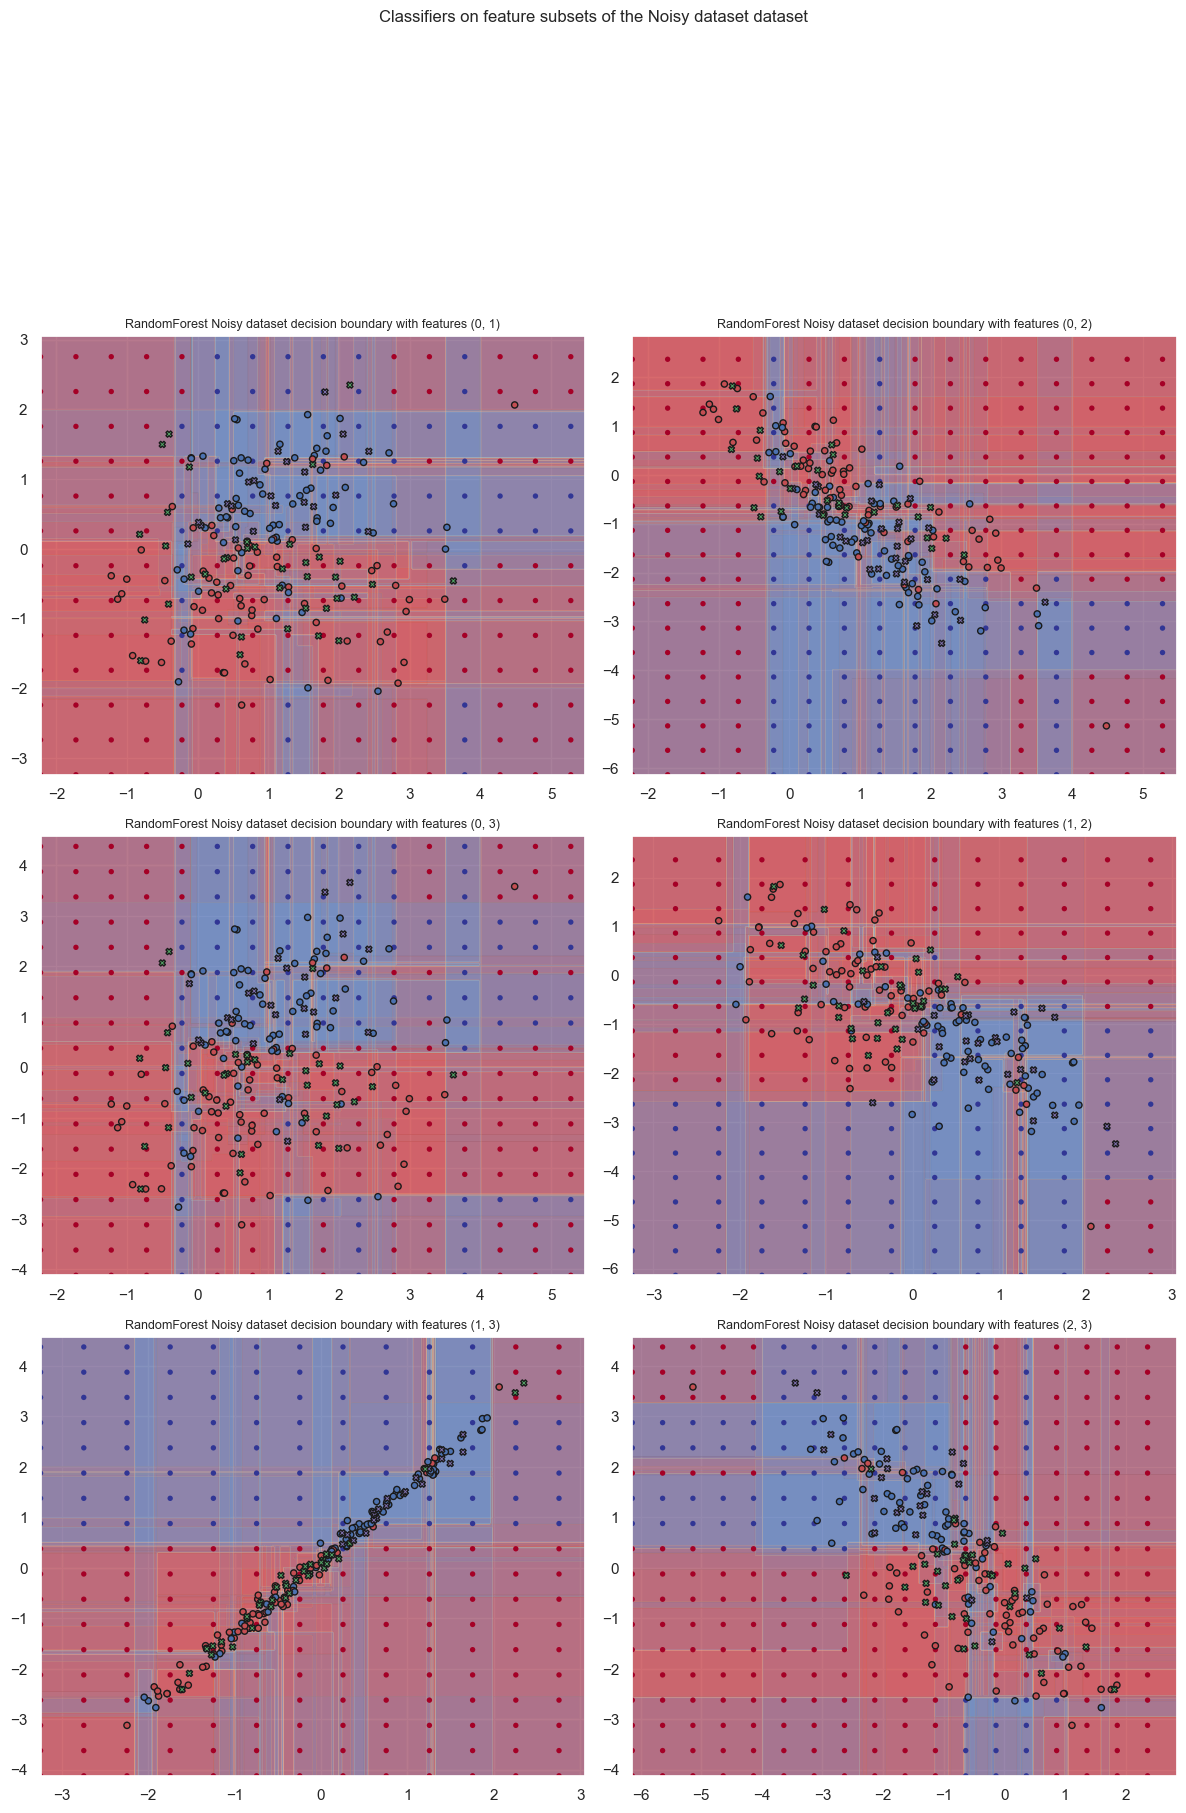

Accuracy of GradientBoosting:
Train:0.7428571428571429
Test:0.5666666666666667


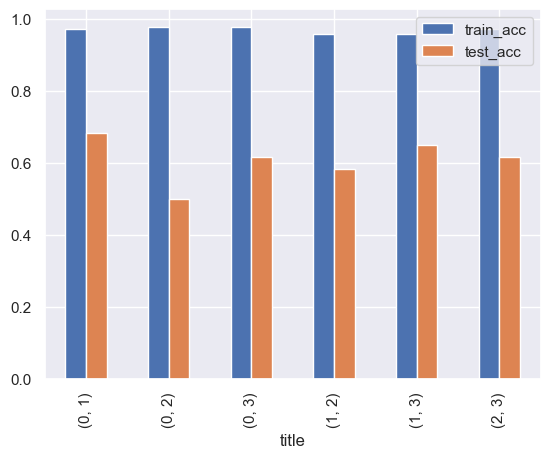

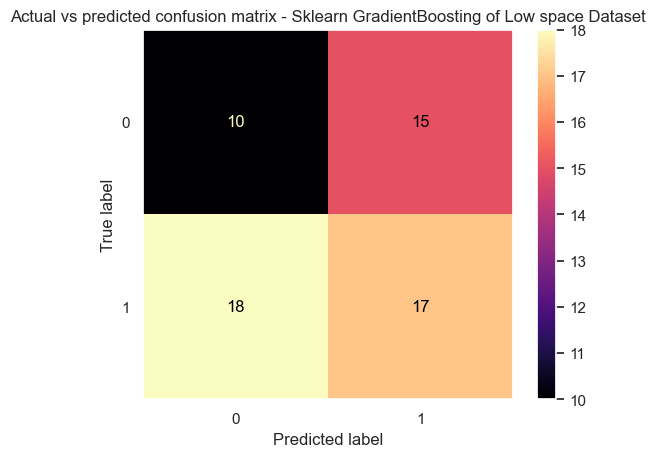

GradientBoosting Low space Dataset with 10 estimators with features (0, 1) has a score of
Train: 0.7285714285714285
Test: 0.5166666666666667
GradientBoosting Low space Dataset with 10 estimators with features (0, 2) has a score of
Train: 0.7285714285714285
Test: 0.5833333333333334
GradientBoosting Low space Dataset with 10 estimators with features (0, 3) has a score of
Train: 0.7714285714285715
Test: 0.5
GradientBoosting Low space Dataset with 10 estimators with features (1, 2) has a score of
Train: 0.7857142857142857
Test: 0.5666666666666667
GradientBoosting Low space Dataset with 10 estimators with features (1, 3) has a score of
Train: 0.7357142857142858
Test: 0.5166666666666667
GradientBoosting Low space Dataset with 10 estimators with features (2, 3) has a score of
Train: 0.7285714285714285
Test: 0.6166666666666667


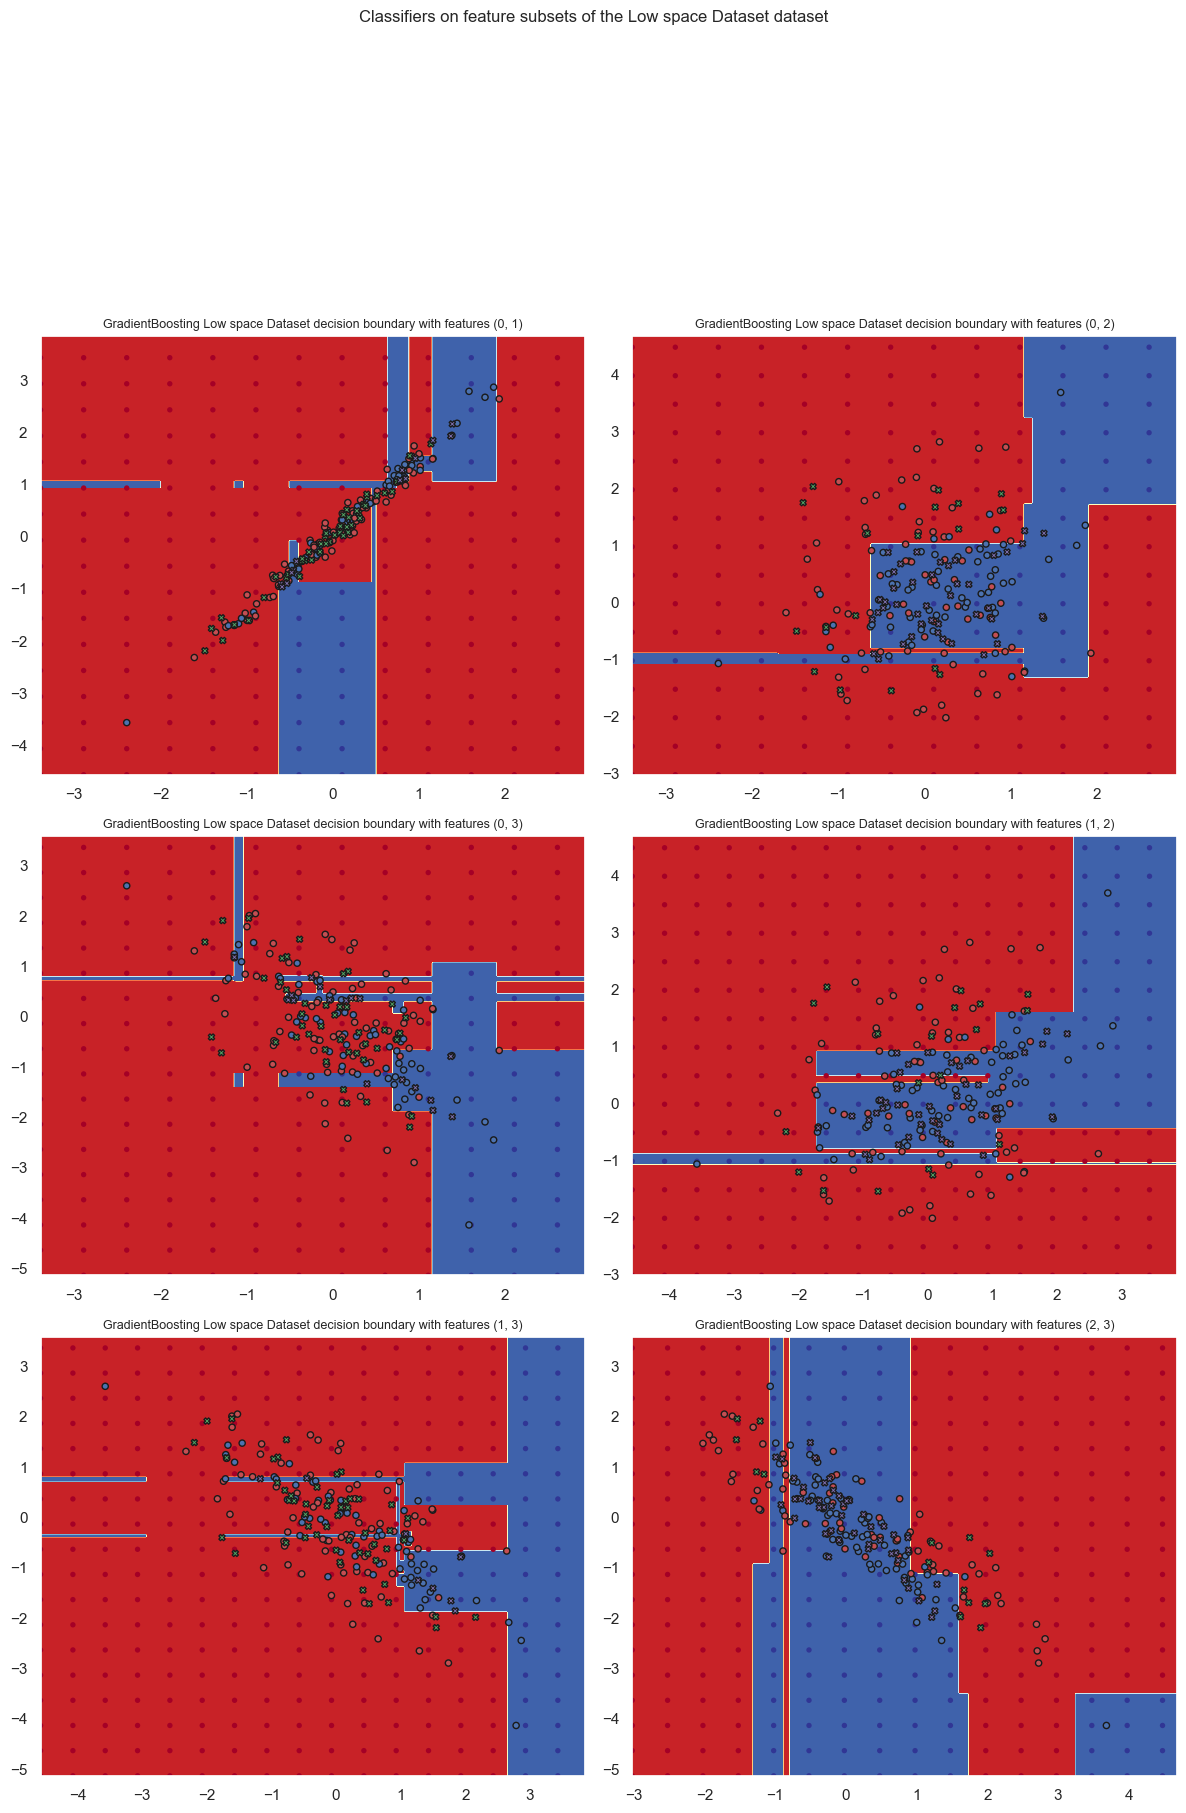

Accuracy of GradientBoosting:
Train:0.8428571428571429
Test:0.7166666666666667


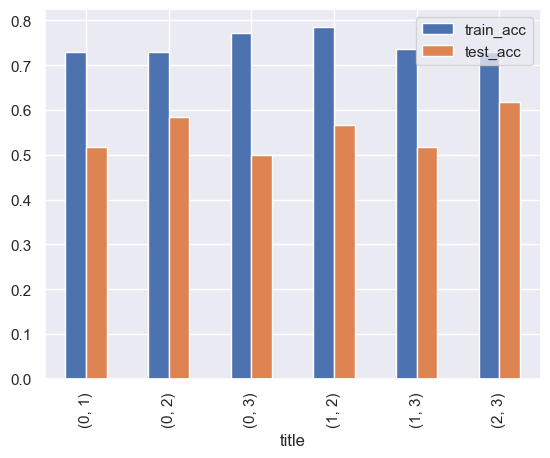

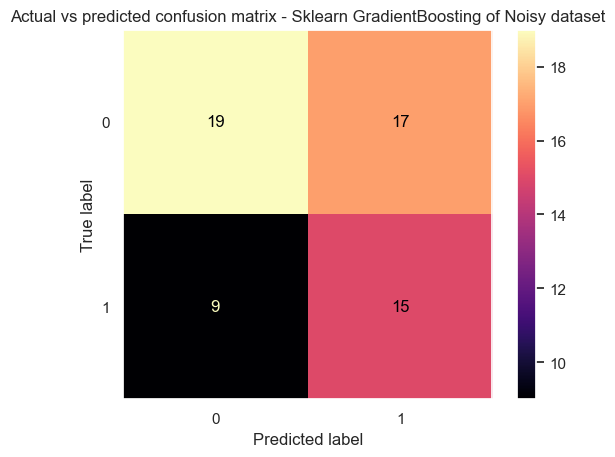

GradientBoosting Noisy dataset with 10 estimators with features (0, 1) has a score of
Train: 0.85
Test: 0.7
GradientBoosting Noisy dataset with 10 estimators with features (0, 2) has a score of
Train: 0.8142857142857143
Test: 0.65
GradientBoosting Noisy dataset with 10 estimators with features (0, 3) has a score of
Train: 0.85
Test: 0.7166666666666667
GradientBoosting Noisy dataset with 10 estimators with features (1, 2) has a score of
Train: 0.8
Test: 0.7
GradientBoosting Noisy dataset with 10 estimators with features (1, 3) has a score of
Train: 0.8
Test: 0.7333333333333333
GradientBoosting Noisy dataset with 10 estimators with features (2, 3) has a score of
Train: 0.8214285714285714
Test: 0.7


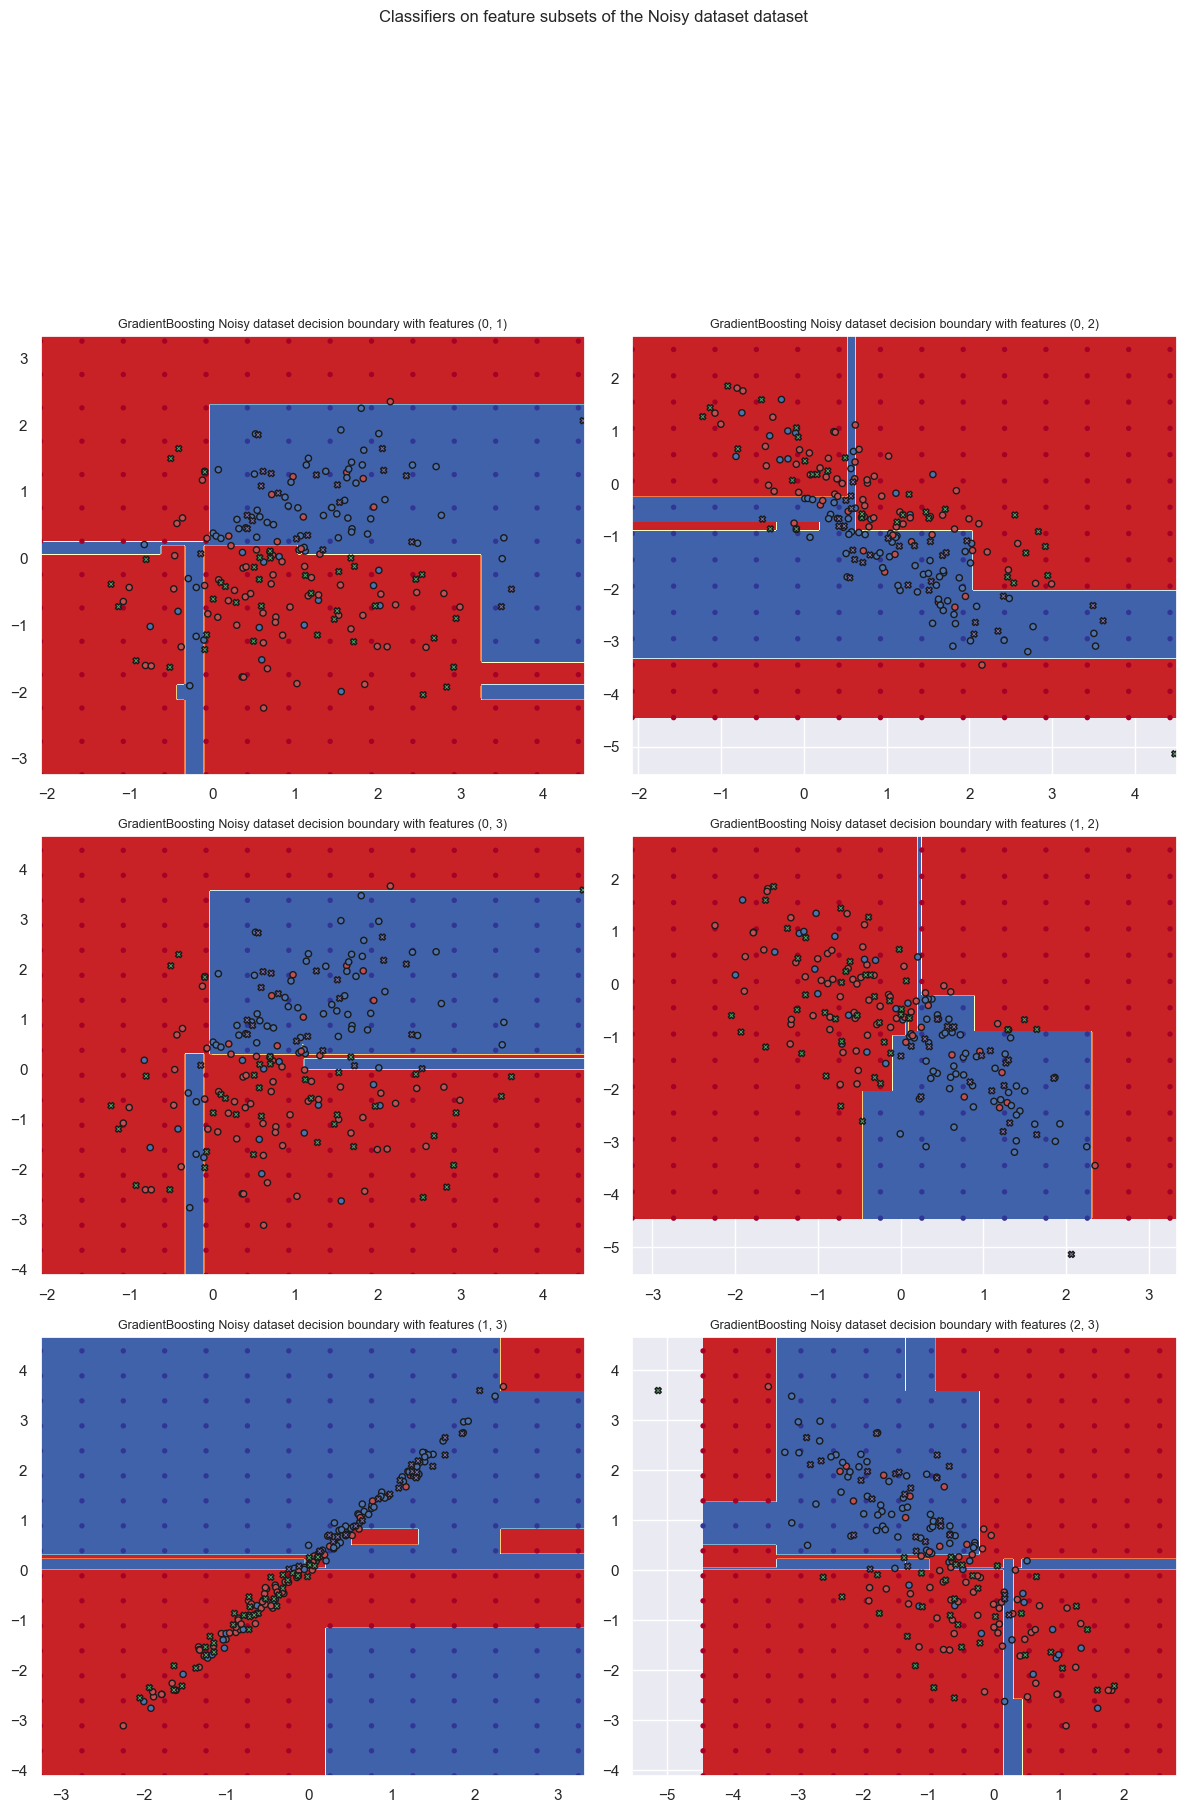

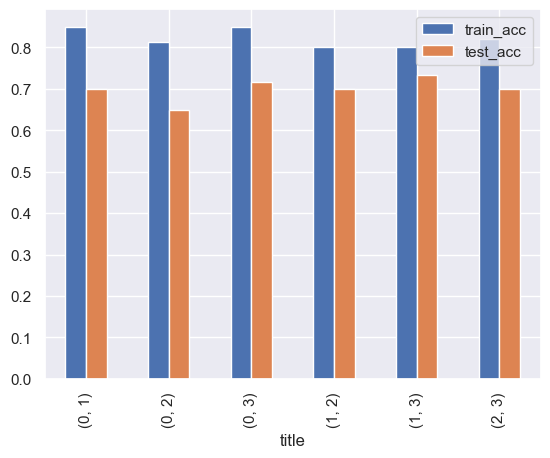

In [429]:
datasets = [{
    'n_samples': 200,
    'n_features': 4,
    'n_informative': 2,
    'n_classes': 2,
    'n_clusters_per_class': 1,
    'flip_y': 0.01, # Default flip value, no noise
    'class_sep': 0.2, # Reduces the space between label classes
    'title': "Low space Dataset"
},{
    'n_samples': 200,
    'n_features': 4,
    'n_informative': 2,
    'n_classes': 2,
    'n_clusters_per_class': 1,
    'flip_y': 0.5, # Makes a noisy dataset
    'class_sep': 1, # Default space seperation
    'title': "Noisy dataset"
}]

additional_models = [
    RandomForestClassifier(n_estimators=10, random_state=42),
    GradientBoostingClassifier(n_estimators=10, random_state=42)
]

for additional_model in additional_models:
    for dataset in datasets:
        X, y = make_classification(
            n_samples = dataset['n_samples'],
            n_features = dataset['n_features'],
            n_informative = dataset['n_informative'],
            n_classes = dataset['n_classes'],
            n_clusters_per_class = dataset['n_clusters_per_class'],
            flip_y = dataset['flip_y'],
            class_sep = dataset['class_sep'],
            random_state=42
        )
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test
            
        # Train Adaboost Classifer
        additional_res = additional_model.fit(X_train, y_train)

        #Predict the response for test dataset
        y_train_pred = additional_res.predict(X_train)
        y_pred = additional_res.predict(X_test)
    
        model_title = type(additional_model).__name__[: -len("Classifier")]

        accuracies_list.append({
            "title": f"{model_title} of {dataset['title']}",
            "train_acc": accuracy_score(y_train, y_train_pred),
            "test_acc": accuracy_score(y_test, y_pred)
        })
        
        # Model Accuracy, how often is the classifier correct?
        print(f"Accuracy of {model_title}:\nTrain:{accuracy_score(y_train, y_train_pred)}\nTest:{accuracy_score(y_test, y_pred)}")

        model_title = type(additional_model).__name__[: -len("Classifier")]
        matrix_plot = confusion_matrix(y_test, sklearn_pred)
        cm_display = ConfusionMatrixDisplay(confusion_matrix=matrix_plot)
        cm_display.plot(cmap="magma")
        plt.title(
            f"Actual vs predicted confusion matrix - Sklearn {model_title} of {dataset['title']}"
        )
        plt.grid(False)
        plt.show()
        
        print_plots(additional_model, X_train, X_test, y_train, y_test, dataset['title'])

<Axes: xlabel='title'>

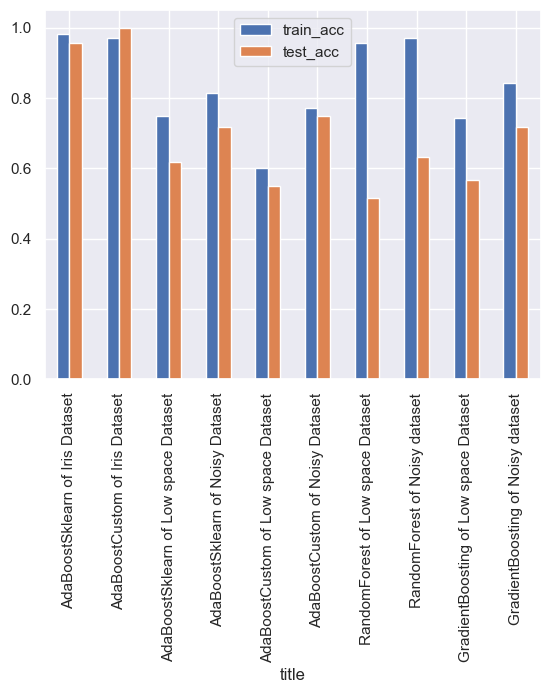

In [430]:
accuracies_list_df = pd.DataFrame.from_records(accuracies_list)
accuracies_list_df.plot.bar(x='title', y=['train_acc', 'test_acc'])

In [431]:
# Test and visualize

# Use of generative AI
Please use the cell below to describe your use of generative AI in this assignment. 